## Ⅰ.Intro

### 1. 테이블의 내용
고객이 각 귀속년도별 (근로 / 사업 / 기타) 소득에 대한 예상환급액과 수수료를 조회한 뒤 결제를 하거나 하지 않은 여부를 저장  

### 2. 컬럼 정보
- age: 고객의 만 나이입니다. 
- gender: 고객의 성별입니다.
- year: 소득이 발생한 연도(귀속년도)입니다.
- refund: 예상환급액입니다.
- fee: 수수료입니다.
- has_paid: 수수료를 결제했는지의 여부
- income_근로: 고객의 근로소득(월급/일용직급여)
- income_사업: 고객의 사업소득(프리랜서 소득)
- income_기타: 고객의 기타소득(그외 기타 소득)

### 3. 질문

- 고객의 결제여부에 영향을 미치는 요인들은 무엇인가요? 
- 고객의 수수료 결제금액의 합을 높히기 위해서는 어떻게 해야 할까요?

### 4. 자료 수집 및 아이디어 파악 
4.1 납부세액 혹은 환급세액의 결정방법
    소득을 3범주로 하여, 기장의무가 달라진다.  
    
<https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=fobi52&logNo=221270380307>  
-> income_근로,사업,기타를 카테고리화 하거나 3가지를 합쳐서 카테고리화 하여 분석하면 의미있는 결과를 얻지 않을까?

4.2 각 소득의 정의
- 사업소득 : 개인이 지속적으로 일을 하고 얻는 소득
- 기타소득 : 일시적으로 발생한 소득

4.3 refund(예상환급액) 결정 방식 
- 예상환급액 : 기납부세액 - 결정세액 (기납부세액이 결정세액보다 적을경우, refund가 마이너스값이 가능함)  

https://help.jobis.co/hc/ko/articles/900003046406-%EB%96%BC%EC%9D%B8-%EC%84%B8%EA%B8%88-%EC%82%BC%EC%A9%9C%EC%82%BC-%ED%99%98%EA%B8%89-%EA%B0%80%EB%8A%A5vs%EB%B6%88%EA%B0%80%EB%8A%A5-%EC%BC%80%EC%9D%B4%EC%8A%A4

### 5. 가설 설정
1) 나이가 결제여부에 영향을 줄 것이다.  
   (삼쩜삼 라이브에서도 '20대~30대를 찾는다'는 식으로 나이를 타겟 마케팅했으니 나이 그룹별로 유입 수 대비 전환율을 살펴볼 필요가 있음)     
   
2) 각 소득원(사업,근로,기타)의 크기나 소득원의 존재여부가 결제여부에 영향을 줄 것이다.

3) 상식처럼 예상환급액이 클수록 그리고 수수료의 차이가 적을수록 결제여부에 영향을 줄 것이다.

### 6. EDA

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
sns.set(font="Malgun Gothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid')

In [2]:
df=pd.read_csv('Jobis_3o3.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   age        100000 non-null  float64
 1   gender     100000 non-null  object 
 2   year       100000 non-null  int64  
 3   refund     100000 non-null  float64
 4   fee        100000 non-null  float64
 5   has_paid   100000 non-null  bool   
 6   income_근로  40791 non-null   float64
 7   income_사업  78227 non-null   float64
 8   income_기타  25260 non-null   float64
dtypes: bool(1), float64(6), int64(1), object(1)
memory usage: 6.2+ MB


In [4]:
df.describe()

,age,year,refund,fee,income_근로,income_사업,income_기타
count,100000.00000,100000.000000,1.000000e+05,100000.000000,4.079100e+04,7.822700e+04,2.526000e+04
mean,29.00096,2018.111300,2.081422e+05,7247.641000,6.432597e+06,1.511712e+06,6.362834e+05
std,7.76819,1.495812,3.071744e+05,11926.896979,6.583716e+06,2.449810e+06,1.484947e+06
min,15.00000,2015.000000,-8.265000e+06,400.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,24.00000,2017.000000,3.300000e+04,400.000000,1.616000e+06,1.770000e+05,8.200000e+04
50%,27.00000,2018.000000,9.900000e+04,4300.000000,4.507000e+06,6.190000e+05,2.130000e+05
75%,31.00000,2019.000000,2.540000e+05,8500.000000,9.301000e+06,1.601000e+06,5.820000e+05
max,81.00000,2020.000000,7.725000e+06,307000.000000,1.823350e+08,3.993400e+07,6.281000e+07


#### 6-1) 지불여부를 숫자로 바꾸고 수수료를 곱한 새로운 변수(Target)를 생성한다.

In [5]:
df['Target']=df.has_paid*df.fee

#### 6-2) 환급액에서 수수료를 뺀 gain이라는 변수를 생성 및 지불여부 숫자형 변수로 전환

In [6]:
gain=df.refund-df.fee
df['gain']=gain

In [7]:
df['has_paid']=df['has_paid'].astype('int')

#### 6-3) 나이를 카테고리화

- 나이를 카테고리화하는 기준으로는 사분위수를 사용한 값 범위를 활용하였다.  
    다만, 상위 이상값들의 결제금액합이 전체 데이터의 19%에 해당해 상위 이상값은 두그룹으로 나눴다.

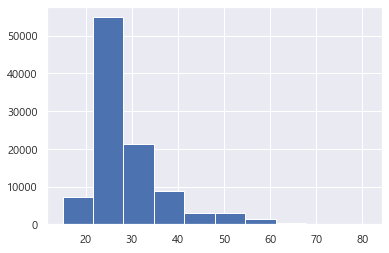

In [8]:
df.age.hist()

In [9]:
IQR= df.age.quantile(0.75)-df.age.quantile(0.25)
Q3= df.age.quantile(0.25)
Q1=df.age.quantile(0.75)

In [10]:
df.query("(age > @Q1-1.5*@IQR) and (age < @Q3+1.5*@IQR)").age.describe()

count    79872.000000
mean        26.467085
std          3.310020
min         21.000000
25%         24.000000
50%         26.000000
75%         29.000000
max         34.000000
Name: age, dtype: float64

In [11]:
# 상위 이상값들의 총 결제금액에서 차지하는 비중(%) 
str(round((df.query("age > 34").Target.sum()/df.Target.sum())*100,2))+'%'

'19.56%'

In [12]:
# 하위
str(round((df.query("age < 21").Target.sum()/df.Target.sum())*100,2))+'%'

'2.45%'

In [13]:
df.query("age > 34").age.quantile(0.25)

37.0

In [14]:
df.query("age > 34").age.quantile(0.75)

48.0

In [15]:
# 나이 카테고리 변수 생성
cat_1=pd.cut(df.age,bins=[-1,21,24,26,29,34,37,48,100]).astype('str').str.rstrip(']').str.lstrip('(')
df['ag_cat']=cat_1

#### 6-4) 추가로 각 소득원의 유무와 각 데이터가 소득원을 몇개가지고 있는지도 변수로 생성

In [16]:
df['근로yn']=df.income_근로.notnull().astype('int')
df['사업yn']=df.income_사업.notnull().astype('int')
df['기타yn']=df.income_기타.notnull().astype('int')
df['소득notnull여부']=pd.concat([df.income_근로.notnull(),df.income_사업.notnull(),df.income_기타.notnull()],axis=1).sum(1).astype('str')

In [17]:
df['근로yn']=df['근로yn'].fillna('0').astype('str')
df['사업yn']=df['사업yn'].fillna('0').astype('str')
df['기타yn']=df['기타yn'].fillna('0').astype('str')

In [18]:
df['소득종류']=df['근로yn']+df['사업yn']+df['기타yn']
df['소득종류']

0        110
1        101
2        010
3        010
4        110
        ... 
99995    001
99996    010
99997    110
99998    010
99999    110
Name: 소득종류, Length: 100000, dtype: object

#### 6-5) 성별컬럼 결측값처리

In [19]:
df.gender.value_counts()

M    50477
F    49501
-       22
Name: gender, dtype: int64

- 성별 값이 '-'인 데이터는 22건이 존재한다. 그리고 모두 소득원에 대한 정보가 없다. (위 3가지 컬럼에 집계되지 않는 소득이 있는 것으로 판단한다.) 
- 이중 실제 결제 된 데이터가 4건에 해당한다. 이는, 총 결제데이터 6만4천건 정도의 데이터규모에서 극히 일부분이며, 결제 여부를 고려하지 않는 10만건 중에 성별 결측치 데이터는 22건으로 극 소수이기 때문에 제외한다.

In [20]:
df.loc[df.gender=='-',:]

,age,gender,year,refund,fee,has_paid,income_근로,income_사업,income_기타,Target,gain,ag_cat,근로yn,사업yn,기타yn,소득notnull여부,소득종류
2613,27.0,-,2016,559000.0,12800.0,0,NaN,NaN,NaN,0.0,546200.0,"26, 29",0,0,0,0,000
4101,27.0,-,2017,209000.0,4300.0,0,NaN,NaN,NaN,0.0,204700.0,"26, 29",0,0,0,0,000
9574,42.0,-,2015,175000.0,4300.0,0,NaN,NaN,NaN,0.0,170700.0,"37, 48",0,0,0,0,000
20536,26.0,-,2017,845000.0,25100.0,0,NaN,NaN,NaN,0.0,819900.0,"24, 26",0,0,0,0,000
28211,26.0,-,2016,650000.0,12800.0,0,NaN,NaN,NaN,0.0,637200.0,"24, 26",0,0,0,0,000
36217,27.0,-,2018,124000.0,3400.0,0,NaN,NaN,NaN,0.0,120600.0,"26, 29",0,0,0,0,000
37674,27.0,-,2015,252000.0,8500.0,0,NaN,NaN,NaN,0.0,243500.0,"26, 29",0,0,0,0,000
38223,53.0,-,2015,6000.0,400.0,0,NaN,NaN,NaN,0.0,5600.0,"48, 100",0,0,0,0,000
38441,23.0,-,2018,110000.0,3000.0,0,NaN,NaN,NaN,0.0,107000.0,"21, 24",0,0,0,0,000
41454,41.0,-,2015,122000.0,4300.0,1,NaN,NaN,NaN,4300.0,117700.0,"37, 48",0,0,0,0,000


In [21]:
df.query("(gender=='-') and (has_paid==1)")

,age,gender,year,refund,fee,has_paid,income_근로,income_사업,income_기타,Target,gain,ag_cat,근로yn,사업yn,기타yn,소득notnull여부,소득종류
41454,41.0,-,2015,122000.0,4300.0,1,NaN,NaN,NaN,4300.0,117700.0,"37, 48",0,0,0,0,000
47966,41.0,-,2017,35000.0,400.0,1,NaN,NaN,NaN,400.0,34600.0,"37, 48",0,0,0,0,000
53924,41.0,-,2016,179000.0,4300.0,1,NaN,NaN,NaN,4300.0,174700.0,"37, 48",0,0,0,0,000
60508,22.0,-,2018,33000.0,400.0,1,NaN,NaN,NaN,400.0,32600.0,"21, 24",0,0,0,0,000


- 성별결측치 제거

In [22]:
df=df.loc[df.gender!='-',:]

- 환급세액이 마이너스인 경우의 제거여부

In [23]:
df.query("refund <0 and has_paid ==1.0")

,age,gender,year,refund,fee,has_paid,income_근로,income_사업,income_기타,Target,gain,ag_cat,근로yn,사업yn,기타yn,소득notnull여부,소득종류
10034,34.0,M,2015,-231000.0,8500.0,1,8989000.0,1714000.0,NaN,8500.0,-239500.0,"29, 34",1,1,0,2,110
10624,25.0,F,2018,-7000.0,400.0,1,7508000.0,28000.0,NaN,400.0,-7400.0,"24, 26",1,1,0,2,110
29515,41.0,F,2017,-10000.0,400.0,1,19718000.0,162000.0,128000.0,400.0,-10400.0,"37, 48",1,1,1,3,111
54256,48.0,F,2018,-948000.0,3000.0,1,8157000.0,3975000.0,NaN,3000.0,-951000.0,"37, 48",1,1,0,2,110
57756,38.0,F,2017,-107000.0,4300.0,1,16619000.0,737000.0,NaN,4300.0,-111300.0,"37, 48",1,1,0,2,110
68881,33.0,M,2016,-322000.0,400.0,1,NaN,57000.0,NaN,400.0,-322400.0,"29, 34",0,1,0,1,010
98352,33.0,M,2018,-8265000.0,4300.0,1,NaN,690000.0,NaN,4300.0,-8269300.0,"29, 34",0,1,0,1,010


- 환급세액이 마이너스인 경우는 기납부 세액이 결정세액보다 적은 경우이므로 세액의 특성상 존재하는 데이터이다.  
- 이 데이터들은 오류 데이터로 보지 않고 삭제하지 않는다. 또한 전체 데이터에서 수수료중 빈도수가 높은 400과 4300과 8500에 해당하는 데이터   이므로 대표성이 있다고 볼 수 있다.

In [24]:
df

,age,gender,year,refund,fee,has_paid,income_근로,income_사업,income_기타,Target,gain,ag_cat,근로yn,사업yn,기타yn,소득notnull여부,소득종류
0,27.0,F,2019,5000.0,400.0,0,10001000.0,61000.0,NaN,0.0,4600.0,"26, 29",1,1,0,2,110
1,34.0,M,2018,100000.0,1700.0,1,18092000.0,NaN,1815000.0,1700.0,98300.0,"29, 34",1,0,1,2,101
2,28.0,F,2017,289000.0,11500.0,0,NaN,1461000.0,NaN,0.0,277500.0,"26, 29",0,1,0,1,010
3,27.0,M,2019,410000.0,16200.0,0,NaN,2471000.0,NaN,0.0,393800.0,"26, 29",0,1,0,1,010
4,26.0,F,2016,114000.0,4300.0,1,0.0,689000.0,NaN,4300.0,109700.0,"24, 26",1,1,0,2,110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,27.0,F,2019,301000.0,11900.0,1,NaN,NaN,680000.0,11900.0,289100.0,"26, 29",0,0,1,1,001
99996,62.0,F,2019,77000.0,1300.0,1,NaN,463000.0,NaN,1300.0,75700.0,"48, 100",0,1,0,1,010
99997,24.0,M,2020,9000.0,400.0,0,7923000.0,54000.0,NaN,0.0,8600.0,"21, 24",1,1,0,2,110
99998,24.0,M,2019,34000.0,400.0,1,NaN,204000.0,NaN,400.0,33600.0,"21, 24",0,1,0,1,010


#### 6-6) 상관관계 파악(피어슨 상관계수)

In [25]:
corr=df.corr()

Text(0.5, 1, 'Feature Correlation')

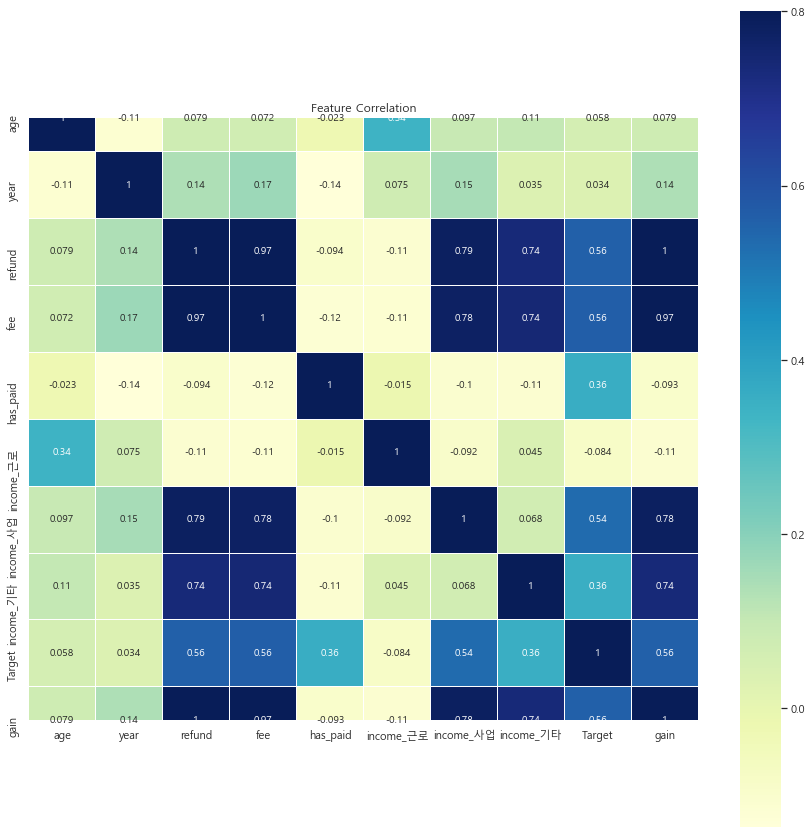

In [26]:
plt.figure(figsize=(15, 15));
sns.heatmap(corr,
            vmax=0.8,
            linewidths=0.01,
            square=True,
            annot=True,
            cmap='YlGnBu');
plt.title('Feature Correlation')

- <U>상관계수 히트맵으로는 결제여부는 약한 상관관계(0.25)가 있는 사업소득 유무를 제외하면,상관관계 있는 변수는 없는 것으로 판단된다.</U>
- 다만, 결제금액인 Target을 보면, 상식적으로 생각하는 것처럼 사업소득, 기타소득,환급액과 수수료에 상관관계가 있다.
- 추가로, 사업소득과 결제금액(Target)은 뚜렷한 양의 상관관계가 있으며, 기타소득과도 결제금액은 어느정도의 상관관계가 있다.

#### 6-7) 명목형(이분형) & 연속형 변수간의 상관관계 파악- Point biserial correlation coefficient(점이연 상관계수)
    이진변수인 결제여부와 연속형 변수인 각 소득 및 나이에 대해 더 정확한 상관관계를 파악하기 위해 점이연 상관계수를 구한다.
참고:
https://het.as.utexas.edu/HET/Software/Scipy/generated/scipy.stats.pointbiserialr.html

In [27]:
from scipy.stats import pointbiserialr
df2=df.dropna().copy()
pointbiserialr(df2.has_paid, df2.income_근로)

PointbiserialrResult(correlation=0.06484126302615116, pvalue=5.164009448485287e-07)

In [28]:
pointbiserialr(df2.has_paid, df2.income_사업)

PointbiserialrResult(correlation=-0.05150567350892119, pvalue=6.716746988526208e-05)

In [29]:
pointbiserialr(df2.has_paid, df2.income_기타)

PointbiserialrResult(correlation=-0.07128786194701822, pvalue=3.381543838127945e-08)

In [30]:
pointbiserialr(df2.has_paid, df2.age)

PointbiserialrResult(correlation=0.038634873470940675, pvalue=0.002797610230327669)

- 점이연 상관분석을 통해 각 변수들의 상관계수(correlation)를 보면 대부분 +-0.1의 범위에 해당되어 상관관계가 없다고 볼 수 있다.

In [31]:
# 메모리를 위해 df2변수 삭제
del df2

####  6-8) 범주형 변수간의 상관관계 파악 - Cramer's V
#####    성별이나 년도, 각 소득 존재여부, 고객 당 보유한 소득 갯수 여부등의 범주형 번수에 대한 상관관계를 파악한다.   
#####   범주형 변수간 상관관계 파악하는 통계적 기법
#####   비교 대상 범주 대상이 3개 이상인 경우 사용한다.
https://www.kaggle.com/chrisbss1/cramer-s-v-correlation-matrix

In [32]:
data = df[[i for i in df.columns if i in ('gender','ag_cat','has_paid','근로yn','사업yn','기타yn','소득notnull여부','year')]]

data.head()

,gender,year,has_paid,ag_cat,근로yn,사업yn,기타yn,소득notnull여부
0,F,2019,0,"26, 29",1,1,0,2
1,M,2018,1,"29, 34",1,0,1,2
2,F,2017,0,"26, 29",0,1,0,1
3,M,2019,0,"26, 29",0,1,0,1
4,F,2016,1,"24, 26",1,1,0,2


In [33]:
from sklearn import preprocessing

label = preprocessing.LabelEncoder()
data_encoded = pd.DataFrame() 

for i in data.columns :
  data_encoded[i]=label.fit_transform(data[i])

In [34]:
data_encoded.head()

,gender,year,has_paid,ag_cat,근로yn,사업yn,기타yn,소득notnull여부
0,0,4,0,3,1,1,0,2
1,1,3,1,4,1,0,1,2
2,0,2,0,3,0,1,0,1
3,1,4,0,3,0,1,0,1
4,0,1,1,2,1,1,0,2


In [35]:
from scipy.stats import chi2_contingency
import numpy as np


def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  return (stat/(obs*mini))

In [36]:
rows= []

for var1 in data_encoded:
  col = []
  for var2 in data_encoded :
    cramers =cramers_V(data_encoded[var1], data_encoded[var2]) # Cramer's V test
    col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
  rows.append(col)
  
cramers_results = np.array(rows)
df1 = pd.DataFrame(cramers_results, columns = data_encoded.columns, index =data_encoded.columns)



df1

,gender,year,has_paid,ag_cat,근로yn,사업yn,기타yn,소득notnull여부
gender,1.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00
year,0.00,1.00,0.04,0.01,0.03,0.02,0.01,0.03
has_paid,0.00,0.04,1.00,0.00,0.01,0.06,0.00,0.10
ag_cat,0.02,0.01,0.00,1.00,0.04,0.01,0.01,0.02
근로yn,0.00,0.03,0.01,0.04,1.00,0.01,0.02,0.76
사업yn,0.00,0.02,0.06,0.01,0.01,1.00,0.15,0.37
기타yn,0.00,0.01,0.00,0.01,0.02,0.15,1.00,0.26
소득notnull여부,0.00,0.03,0.10,0.02,0.76,0.37,0.26,1.00


Text(0.5, 1, 'Feature Correlation')

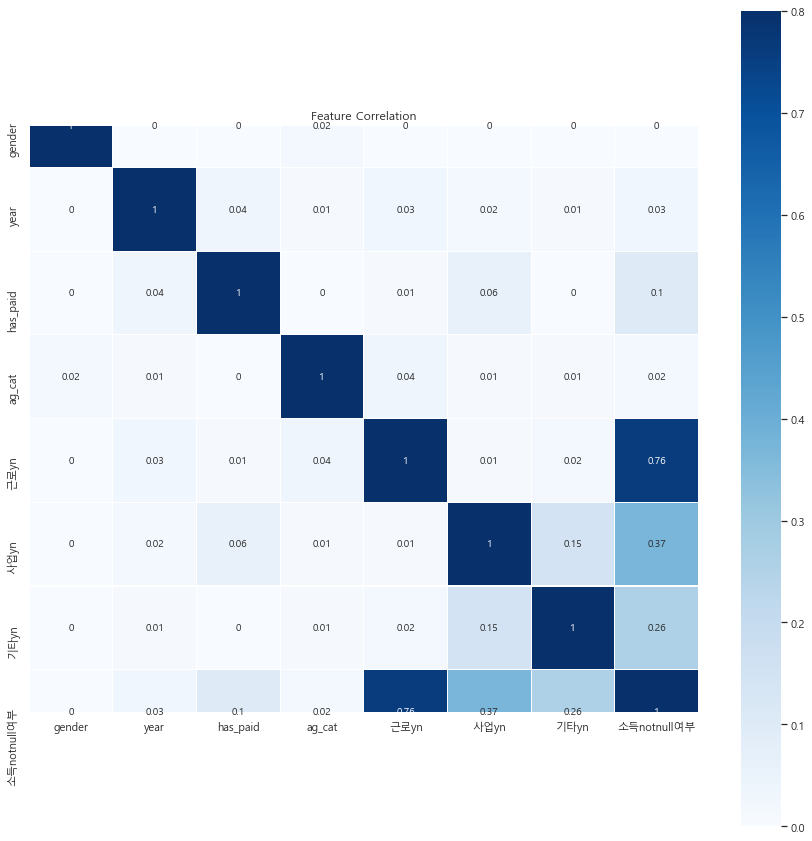

In [37]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.figure(figsize=(15, 15));
sns.heatmap(df1,
            vmax=0.8,
            linewidths=0.01,
            square=True,
            annot=True,
            cmap='Blues');
plt.title('Feature Correlation')

- <U>아쉽게도 통계적으로 범주형 변수간의 상관관계는 없는 것으로 판단된다.</U>

***

## Ⅱ. 고객의 결제여부에 영향을 미치는 요인 과 총결제금액 합의 개선을 위한 분석

### 1. 머신러닝 , 로지스틱 회귀분석을 통해 결제여부에 영향을 미치는 변수 파악
#### 1-1) XGB분류모델을 통해 지불여부를 target value로 설정하고, 나머지 변수를 학습
- 세세하게 통계적 기법으로 지불여부에 대한 차이여부를 검정하거나,시각화해서 비교하기 전에 머신러닝 방법 중 xgboost 분류모델을 통해 어떠한 변수가 분류를 할 때 중요한지 파악   

In [38]:
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.preprocessing import MinMaxScaler
from sklearn.inspection import permutation_importance
scaler=MinMaxScaler()

In [39]:
X=df.reindex(['gender','year', 'refund', 'fee','income_근로','income_사업', 'income_기타','gain','age'],axis=1)
X=X.fillna(0)

# 분류 목적 대상
y=df.has_paid

#인코딩
X=pd.get_dummies(X)
#스케일링
X.iloc[:,:8]=scaler.fit_transform(X.iloc[:,:8])
X

,year,refund,fee,income_근로,income_사업,income_기타,gain,age,gender_F,gender_M
0,0.8,0.517198,0.000000,0.054850,0.001528,0.000000,0.527427,0.181818,1,0
1,0.6,0.523139,0.004240,0.099224,0.000000,0.028897,0.533400,0.287879,0,1
2,0.4,0.534959,0.036204,0.000000,0.036585,0.000000,0.544823,0.196970,1,0
3,0.8,0.542527,0.051533,0.000000,0.061877,0.000000,0.552237,0.181818,0,1
4,0.2,0.524015,0.012720,0.000000,0.017253,0.000000,0.534126,0.166667,1,0
...,...,...,...,...,...,...,...,...,...,...
99995,0.8,0.535710,0.037508,0.000000,0.000000,0.010826,0.545562,0.181818,1,0
99996,0.8,0.521701,0.002935,0.000000,0.011594,0.000000,0.531959,0.712121,1,0
99997,1.0,0.517448,0.000000,0.043453,0.001352,0.000000,0.527682,0.136364,0,1
99998,0.8,0.519012,0.000000,0.000000,0.005108,0.000000,0.529275,0.136364,0,1


In [40]:
y

0        0
1        1
2        0
3        0
4        1
        ..
99995    1
99996    1
99997    0
99998    1
99999    1
Name: has_paid, Length: 99978, dtype: int32

In [41]:
xgb_clf=XGBClassifier(n_estimators=100,random_state=42,learning_rate=0.3,use_label_encoder=False)
xgb_clf.fit(X,y)

[21:06:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

#### 1-2) 변수중요도 파악(  순수도 기반의 feature importance와 개별 변수를 suffle하는 permutaion importance를 모두 사용함)

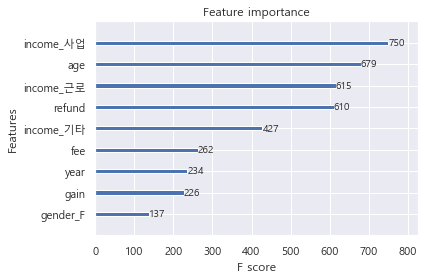

In [42]:
plt.rcParams['font.family'] = 'Malgun Gothic'
fig, ax = plt.subplots()
plot_importance(xgb_clf,ax=ax)
plt.tight_layout()
plt.savefig('fig1.png', dpi=900)


- 제일 높은 변수중요도를 가진 변수는 사업소득이고 기타소득과 근로소득의 경우도 상위권에 해당한다.
- 그리고, refund는 변수중요도가 상위권이며, 직관적으로도 알 수 있는 것처럼 결제 여부에 영향을 미치는 변수이다.
- 아래의 permutation feature importance에서도 사업소득이 제일 중요하다는 것을 알 수 있다.
- 나이 변수의 경우, permutation importance에서는 중요도가 내려갔는데, 이는 나이를 category변수로 변환해서 확인할 필요가 있다.
- 변수에 각 소득원의 유무(예: 근로yn)를 넣고 학습시켰을 때 소득원의 유무는 변수중요도가 높지 않았다. 

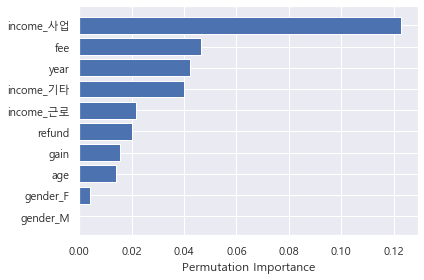

In [43]:
plt.rcParams['font.family'] = 'Malgun Gothic'
perm_importance = permutation_importance(xgb_clf, X, y)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.tight_layout()
plt.savefig('fig2.png', dpi=900)

#### 1-3) 로지스틱 회귀분석을 통해 has_paid를 종속변수로 두고 각 회귀계수가 결제 여부에 어떻게 영향을 미치는지 확인

- 맨 밑의 result 결과를 보면 7가지 모든 변수의 p_value가 0.01 이하로 유의수준 99%에서 종속변수에 영향을 주는 유의한 변수임을 알 수 있다.  
- 편회귀계수값의 부호를 통해 종속변수에 미치는 영향의 방향을 파악할 수 있다. 
- 편회귀계수의 값이 양수라면 결제여부가 '1'일 확률이 높아진다는 뜻이다. 반대로 음수라면 결제여부의 값이 '0'일 확률이 높아진다는 뜻이다.  
- 따라서 모형의 회귀계수 분석결과는 다음과 같다. 
- <U>수수료가 낮을수록 결제할 확률이 높다. 그리고 나이가 낮을수록, 년도 기준으로 과거 데이터일수록 결제확률이 높다.</U>
- <U>마지막으로 환급금액,근로소득,사업소득 그리고 기타소득이 높을수록 결제할 확률이 높다.</U>

In [44]:
import statsmodels.api as sm

X2=df.reindex(['refund', 'fee','income_근로','income_사업', 'income_기타','age','year','has_paid'],axis=1)
y=X2.has_paid
X2=X2.drop('has_paid',axis=1)
X2=X2.fillna(0)

#스케일링(AIC와 BIC값이 낮아짐)
X2=scaler.fit_transform(X2)
X2=pd.DataFrame(X2,columns=['refund', 'fee','income_근로','income_사업', 'income_기타','age','year'],index=y.index)
logit = sm.Logit(y,X2) #로지스틱 회귀분석 시행
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.626409
         Iterations 6


In [45]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.036      
Dependent Variable: has_paid         AIC:              125268.2304
Date:               2021-08-21 21:06 BIC:              125334.8193
No. Observations:   99978            Log-Likelihood:   -62627.    
Df Model:           6                LL-Null:          -64942.    
Df Residuals:       99971            LLR p-value:      0.0000     
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
            Coef.    Std.Err.     z      P>|z|    [0.025    0.975] 
-------------------------------------------------------------------
refund       2.7960    0.0416   67.2708  0.0000    2.7145    2.8775
fee        -16.3600    0.4132  -39.5960  0.0000  -17.1698  -15.5502
income_근로    4.9278    0.2715   18.1533  0.0000    4.3958    5.4599
income_사업    7.3638    0.2322   31.7118  0.0000    6.9087    7.8190
income_기타   18.7510    1.0650   17.6069  0.0000   16.6637   20.8383
age         -0.9400    0.0589  -15.9543  0.0000   -1.0555   -0.8245
year        -1.0072    0.0241  -41.7157  0.0000   -1.0545   -0.9599
==================================================================

"""

- 통계량에 나와있는 편회귀계수의 값 자체만으로는 각 변수들이 종속변수에 얼마나 영향을 주는지는 파악할 수 없다.  
- 종속변수에 미치는 정도는 오즈비를 통해 파악할 수 있다.  
(오즈비가 1을 기준으로 큰지 작은지를 파악하여 종속변수에 미치는 영향의 방향을 파악할 수 있다. 독립변수가 두개 이상 있을 때는 다른 독립변수를 일정한 값으로 고정한 경우의 오즈비로 해석된다. 아무런 관계없을 때 오즈비는 1이다. 1에서 멀리 떨어질수록 종속변수와의 관계가 강하다는 뜻이다. 즉, 종속변수 여부에 큰 영향을 준다는 뜻이다.
- 오즈비를 구하기 위해 다음의 코드를 사용한다. 
- <U>로지스틱 회귀분석의 결과에 따르면, 수수료or기타소득>사업>근로>나이>연도>환급액 순으로 결제여부에 영향을 준다.</U>

In [46]:
# 오즈비 구하기
np.exp(result.params)

refund       1.637900e+01
fee          7.851593e-08
income_근로    1.380766e+02
income_사업    1.577870e+03
income_기타    1.391440e+08
age          3.906375e-01
year         3.652321e-01
dtype: float64

***

### 2. 머신러닝 , 선형 회귀분석을 통해 결제금액의 합에 영향을 미치는 변수 파악
    결제수수료x결제여부(1)을 Target으로 했으므로 머신러닝에서의 예측변수와 선형회귀에서의 종속변수를 Target으로 놓는다.
#### 2-1) XGB회귀모델을 통해 결제금액를 target value로 설정하고, 나머지 변수를 학습¶

In [47]:
X=df.reindex(['gender','year', 'refund', 'fee','income_근로','income_사업', 'income_기타','age'],axis=1)
X=X.fillna(0)

# 분류 목적 대상
y=df.Target

#인코딩
X=pd.get_dummies(X)
#스케일링
X.iloc[:,:8]=scaler.fit_transform(X.iloc[:,:8])
X

,year,refund,fee,income_근로,income_사업,income_기타,age,gender_F,gender_M
0,0.8,0.517198,0.000000,0.054850,0.001528,0.000000,0.181818,1.0,0
1,0.6,0.523139,0.004240,0.099224,0.000000,0.028897,0.287879,0.0,1
2,0.4,0.534959,0.036204,0.000000,0.036585,0.000000,0.196970,1.0,0
3,0.8,0.542527,0.051533,0.000000,0.061877,0.000000,0.181818,0.0,1
4,0.2,0.524015,0.012720,0.000000,0.017253,0.000000,0.166667,1.0,0
...,...,...,...,...,...,...,...,...,...
99995,0.8,0.535710,0.037508,0.000000,0.000000,0.010826,0.181818,1.0,0
99996,0.8,0.521701,0.002935,0.000000,0.011594,0.000000,0.712121,1.0,0
99997,1.0,0.517448,0.000000,0.043453,0.001352,0.000000,0.136364,0.0,1
99998,0.8,0.519012,0.000000,0.000000,0.005108,0.000000,0.136364,0.0,1


In [48]:
from xgboost import XGBRegressor
xgb_reg=XGBRegressor(n_estimators=100,random_state=42,learning_rate=0.3)
xgb_reg.fit(X,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.3, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

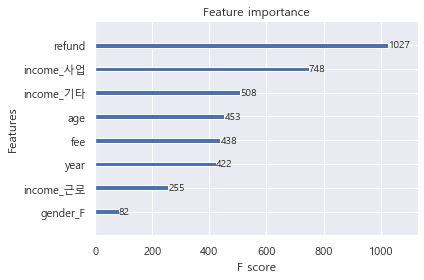

In [49]:
plt.rcParams['font.family'] = 'Malgun Gothic'
fig, ax = plt.subplots()
plot_importance(xgb_reg,ax=ax)
plt.tight_layout()
plt.savefig('fig1.png', dpi=900)

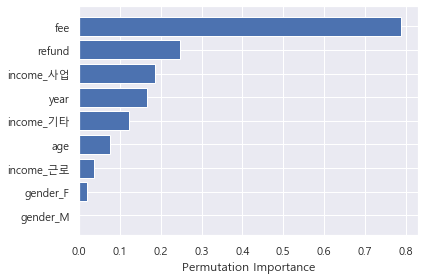

In [50]:
plt.rcParams['font.family'] = 'Malgun Gothic'
perm_importance = permutation_importance(xgb_reg, X, y)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.tight_layout()
plt.savefig('fig2.png', dpi=900)

- 피어슨상관계수 히트맵에서 결제금액(Target)과 (사업, 기타소득)이 상관관계(0.54,0.36)가 있었다.  
    (feature importance기준으로도 사업소득과 기타소득은 상위에 속한다.)
- feature importance 기준 최상위 중요 변수는 환급세액이다.
- permutation importance 기준으로는 수수료가 최상위 중요 변수이고 그다음이 수수료, 사업소득 순이다.
- 나이 변수의 경우, permutation importance에서는 중요도가 내려갔는데, 이는 나이를 category변수로 변환해서 확인할 필요가 있다.
#### 정리하면, 머신러닝을 통해 결제금액의 합을 올리기 위해서 <U>환급액, 사업소득, 수수료를 우선적으로 고려해야 함을 알 수 있다.</U>

#### 2-2) 단계적 변수 선택법 (step wise method)를 통해 변수 선택
(1) p_value와 유의수준을 비교해서 작으면 변수를 해당 변수를 선형모형에 포함시킨다.  
(2) 그리고, 추정된 회귀변수에 대하여 가장 큰 p_value 값을 구한다.  
(3) 최대 p_value가 신뢰도 95%수준의 유의수준(0.05)보다 크거나 같으면 해당변수를 제거하고 1단계로 간다.  

In [51]:
## 전진 단계별 선택법
import warnings

warnings.filterwarnings(action='ignore') 

df2=df.fillna(0)
variables = ['refund', 'fee','income_근로','income_사업', 'income_기타','age','year'] ## 설명 변수 리스트
 
y = df2['Target'] ## 반응 변수
selected_variables = [] ## 선택된 변수들
sl_enter = 0.05
sl_remove = 0.05
 
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables))
    pval = pd.Series(index=remainder) ## 변수의 p-value
    ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 
    ## 선형 모형을 적합한다.
    for col in remainder: 
        X = df2[selected_variables+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(y,X).fit()
        pval[col] = model.pvalues[col]
 
    min_pval = pval.min()
    if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
        selected_variables.append(pval.idxmin())
        ## 선택된 변수들에대해서
        ## 어떤 변수를 제거할지 고른다.
        while len(selected_variables) > 0:
            selected_X = df2[selected_variables]
            selected_X = sm.add_constant(selected_X)
            selected_pval = sm.OLS(y,selected_X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
            max_pval = selected_pval.max()
            if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
                remove_variable = selected_pval.idxmax()
                selected_variables.remove(remove_variable)
            else:
                break
        
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y,sm.add_constant(df2[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break

- 단계적변수선택법을 통해 다음의 변수들이 선택되었다.

In [52]:
selected_variables

['fee', 'income_사업', 'year', 'refund', 'income_근로', 'income_기타']

- 기타소득만 있는 선형모델에서 하나씩 추가해가며 수정된 결정계수를 구하는 선 그래프를 그린다.

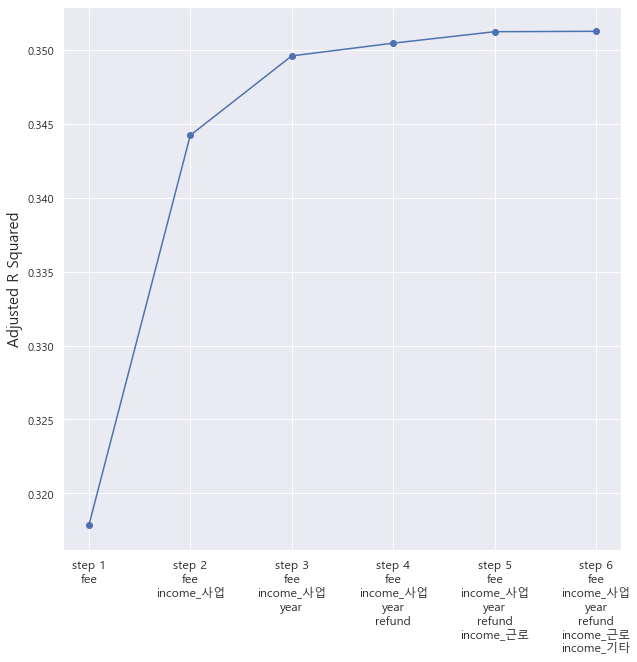

<Figure size 432x288 with 0 Axes>

In [153]:
plt.rcParams['font.family'] = 'Malgun Gothic'
fig = plt.figure(figsize=(10,10))
fig.set_facecolor('white')
 
font_size = 15
plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
plt.plot(steps,adjusted_r_squared, marker='o')
    
plt.ylabel('Adjusted R Squared',fontsize=font_size)
plt.grid(True)
plt.show()
plt.tight_layout()
plt.savefig('fig1.png', dpi=500)

#### 2-3) 단계적 변수선택법에 의해 선택된 변수를 바탕으로 선형회귀분석을 수행

In [54]:
import statsmodels.api as sm
warnings.filterwarnings(action='default')

X2=df.reindex(['fee', 'income_사업', 'year', 'refund', 'income_근로', 'income_기타','Target'],axis=1)
y=X2.Target
X2=X2.drop('Target',axis=1)
X2=X2.fillna(0)

#스케일링(AIC와 BIC값이 낮아짐)
X2=scaler.fit_transform(X2)
X2=pd.DataFrame(X2,columns=['fee', 'income_사업', 'year', 'refund', 'income_근로', 'income_기타'],index=y.index)
logit2 = sm.OLS(y,X2)
result2 = logit2.fit()

In [55]:
result2.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Ordinary least squares
==================================================================================
Model:                  OLS              Adj. R-squared (uncentered): 0.474       
Dependent Variable:     Target           AIC:                         2044743.6860
Date:                   2021-08-21 21:06 BIC:                         2044800.7622
No. Observations:       99978            Log-Likelihood:              -1.0224e+06 
Df Model:               6                F-statistic:                 1.501e+04   
Df Residuals:           99972            Prob (F-statistic):          0.00        
R-squared (uncentered): 0.474            Scale:                       4.4634e+07  
------------------------------------------------------------------------------------
                  Coef.       Std.Err.      t       P>|t|      [0.025       0.975]  
------------------------------------------------------------------------------------
fee             95617.7964    974.1970    98.1504   0.0000   93708.3822   97527.2106
income_사업       30436.9115    559.2866    54.4210   0.0000   29340.7167   31533.1063
year            -2196.6242     72.5654   -30.2710   0.0000   -2338.8515   -2054.3970
refund           4219.1608     94.9263    44.4467   0.0000    4033.1064    4405.2153
income_근로        8454.1402    754.6608    11.2026   0.0000    6975.0144    9933.2661
income_기타       -4194.2749   2384.0934    -1.7593   0.0785   -8867.0686     478.5188
----------------------------------------------------------------------------------
Omnibus:                 54116.027          Durbin-Watson:             2.006      
Prob(Omnibus):           0.000              Jarque-Bera (JB):          7919009.339
Skew:                    1.587              Prob(JB):                  0.000      
Kurtosis:                46.485             Condition No.:             101        
==================================================================================

"""

- summary에서 icome_기타를 제외한 각 변수들의 p_value는 95% 신뢰도에서 유의수준인 0.05보다 작다.
- 그러므로, 통계적으로 'income_기타'변수가 Target을 늘리기 위해 사용하기 어려운 변수이다.

***

<br></br>
### 3. income 데이터 분석

### 3-1) 각 소득원의 유무로 그룹화하고 각 소득원의 유무가 결제여부와 총 결제금액의 합에 영향을 주는지 파악
- 각 소득원에 대해 분석하기 앞서 소득원 3개별로 그룹화하여 각 소득원과 결제여부, 총결제 금액이 어떻게 변하는지 파악해 보자

#### 3-1)-(1) 소득원에 따른 데이터의 특징 파악

- 결제고객 기준 사업소득만 있거나, 근로소득과 사업소득이 둘 다 있는 데이터의 수가 많다.(전체 데이터의 약 71%에 해당된다.)
- 그다음으로 사업+기타소득, 근로+기타소득이 있는 데이터 순이다. 

In [56]:
f1= lambda x: round((x / x.sum()),4)
tempt=df.groupby('소득종류')['has_paid'].sum().sort_values(ascending=False)
pct=tempt.reset_index()[['has_paid']].apply(f1,0)
pct.columns=['pct']
pd.concat([tempt.reset_index(),pct],axis=1).style.background_gradient(cmap ='Blues')

,소득종류,has_paid,pct
0,010,26713,0.413300
1,110,19672,0.304300
2,011,4771,0.073800
3,101,4493,0.069500
4,111,4332,0.067000
5,001,3088,0.047800
6,000,1533,0.023700
7,100,37,0.000600


##### 3-1)-(1)-1. 소득원 종류의 그룹별 결제금액의 합 비교

- 총 결제 금액의합을 기준으로도 사업소득이 있는 고객 그룹(011,111)이 최상위권에 위치한다.
- 결제금액 합(refund*has_paid)을 보면 평균과 중앙값 모두 기존 처럼 사업소득있는 데이터가 1,2위로 제일 높다.

###### 평균

In [57]:
df.groupby('소득종류')['Target'].mean().reset_index().sort_values(by='Target',ascending=False).style.background_gradient(cmap ='Blues')

,소득종류,Target
3,011,5120.108936
7,111,5084.458556
1,001,4709.286394
2,010,4448.952486
6,110,4018.445261
5,101,3652.338129
4,100,1567.105263
0,000,606.549173


###### 중앙값

In [58]:
df.groupby('소득종류')['Target'].median().reset_index().sort_values(by='Target',ascending=False).style.background_gradient(cmap ='Blues')

,소득종류,Target
7,111,900.000000
1,001,400.000000
2,010,400.000000
3,011,400.000000
5,101,400.000000
6,110,400.000000
0,000,0.000000
4,100,0.000000


#### 3-1)-(2) 통계적 분석
 두 개 이상의 집단에 대해 평균비교를 하고자 할 때 기존의 t-test를 사용할 수 없으므로 일원분산분석을 사용하겠다.
 분산분석의 가정인 정규성, 등분산성, 독립성의 충족여부를 파악하고 각 소득원 집단별 평균의 차이가 있는지 확인하겠다.
 ##### 정규성 검정( 콜모고로프 스미르노프 검정 활용)

In [59]:
from scipy.stats import kstest
from scipy.stats import bartlett
from scipy.stats import kruskal
from scipy.stats import mannwhitneyu
kstest(df.has_paid[df.소득종류=='010'].dropna().values, "norm")

KstestResult(statistic=0.5453002629737, pvalue=0.0)

In [60]:
kstest(df.has_paid[df.소득종류=='111'].dropna().values, "norm")

KstestResult(statistic=0.5652752273519654, pvalue=0.0)

In [61]:
kstest(df.has_paid[df.소득종류=='110'].dropna().values, "norm")

KstestResult(statistic=0.5566121714403205, pvalue=0.0)

In [62]:
kstest(df.has_paid[df.소득종류=='100'].dropna().values, "norm")

KstestResult(statistic=0.5, pvalue=4.286778485666113e-18)

In [63]:
kstest(df.has_paid[df.소득종류=='001'].dropna().values, "norm")

KstestResult(statistic=0.5, pvalue=0.0)

In [64]:
kstest(df.has_paid[df.소득종류=='011'].dropna().values, "norm")

KstestResult(statistic=0.5436853908499355, pvalue=0.0)

In [65]:
kstest(df.has_paid[df.소득종류=='101'].dropna().values, "norm")

KstestResult(statistic=0.5, pvalue=0.0)

In [66]:
kstest(df.has_paid[df.소득종류=='000'].dropna().values, "norm")

KstestResult(statistic=0.5, pvalue=0.0)

- 각 소득원 그룹별로 정규성 검정을 수행하였는데, pvalue가 0.05보다 작아 정규성을 만족하지 않는다.

 ##### 등분산성 검정( 바틀렛검정, pvalue가 0.05보다 작기 때문에 등분산성을 충족하지 않는다.)

In [67]:
bartlett(df.has_paid[df.소득종류=='010'],df.has_paid[df.소득종류=='111'],df.has_paid[df.소득종류=='110'],df.has_paid[df.소득종류=='100'],
        df.has_paid[df.소득종류=='001'],df.has_paid[df.소득종류=='011'],df.has_paid[df.소득종류=='101'],df.has_paid[df.소득종류=='000'])

BartlettResult(statistic=771.2116059470692, pvalue=3.0208401469363675e-162)

 ##### 정규성과 등분산성 가정을 만족하지 않고 표본집단이 3개 이상이므로  Kruskal-Wallis test를 진행한다.
 - H0 : 모든 소득원 그룹의 중위수가 같다. vs  H1 : 최소 한 그룹의 중위수가 다르다.

In [68]:
kruskal(df.has_paid[df.소득종류=='010'],df.has_paid[df.소득종류=='111'],df.has_paid[df.소득종류=='110'],df.has_paid[df.소득종류=='100'],
        df.has_paid[df.소득종류=='001'],df.has_paid[df.소득종류=='011'],df.has_paid[df.소득종류=='101'],df.has_paid[df.소득종류=='000'])

KruskalResult(statistic=10731.258274510406, pvalue=0.0)

- 크루스칼왈리스검정의 p-value 값이 0.05보다 작으면 통계적으로 유의미한 차이가 있다는 의미이다. 귀무가설이 기각되고 대립가설이 채택된다.
- 즉, 소득원종류그룹간의 지불여부에 대한 중위수 차이가 있다.

#### 각 그룹별 데이터 규모와 결제 수의 합 및 결제율 확인

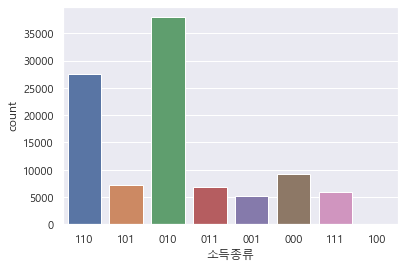

In [69]:
plt.rcParams['font.family'] = 'Malgun Gothic'
sns.countplot(x="소득종류", data=df)
# 근로 사업 기타 순이다.(010 근로n, 사업y 기타 n)

- 각 그룹별 규모로 볼 때 사업소득이 있는 그룹들의 규모가 큰 편이다. 
- 아래 그래프에서 보는 것처럼 각 그룹별로 결제수의 합도 크다.

Text(0.5, 1.0, '소득종류별 결제수 총합')

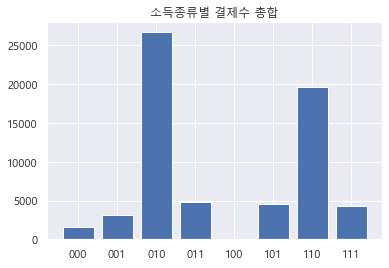

In [70]:
plt.rcParams['font.family'] = 'Malgun Gothic'
a1=df.groupby('소득종류')['has_paid'].sum()
plt.bar(x=a1.index,height=a1)
plt.title("소득종류별 결제수 총합")

- 사업소득이 있는 그룹들의 규모도 크고 결제수도 많으므로, 상대적인 비결제 고객대비 결제고객의 수치인 결제율도 살펴보겠다.
- 111그룹의 경우 데이터 규모도 작고, 결제 데이터 수도 적었으나 결제율은 최상위권에 속하고, 그 밖의 사업소득이 있는 그룹도
  사업소득이 없는 그룹에 비해 높은 결제율을 보인다.

In [71]:
# 소득종류별 결제율 파악

f1= lambda x : x / x.sum()
df.groupby(['소득종류','has_paid'])['age'].count().unstack().apply(f1,axis=1).sort_values(by=1,ascending=False).style.background_gradient(cmap ='Greys')

has_paid,0,1
소득종류,,
111,0.276070,0.723930
110,0.284733,0.715267
010,0.296044,0.703956
011,0.297659,0.702341
101,0.378390,0.621610
001,0.412369,0.587631
100,0.513158,0.486842
000,0.833225,0.166775


### 3-1)-(3). 결과해석
#### 1. 크루스칼왈리스 검정에 의해 통계적으로 소득원의 종류에 따라 결제여부에 통계적으로 유의한 차이가 나타났다.
####    (아래에서 살펴보겠지만  만휘트니 유검정을 통해 사업소득 유무가 결제여부에 영향을 미치는 변수임을 알 수 있다.
#### 2. xgboost에서 feature importacne와 Permutation importacne를 통해서 보면 사업소득이 제일 변수중요도가 높다.
#### 3. 그래프와 테이블을 통해 보면 다음과 같이 판단할 수 있다.  
#####    010 이나 110그룹이 데이터 규모도 크고, 결제 데이터의 수도 많다. 그리고 결제율도 타집단보다 높다.   
#####    그런데, 사업소득을 가진 그 밖의 111이나 011 그룹은 데이터 규모도 작고 결제 데이터의 수도 적은것에 반해 결제율이 높다.  
#####    즉, 데이터의 규모나 결제 데이터의 수에 상관없이 사업소득이 있는 그룹의 결제율이 타 그룹보다 높다.  
#####    이러한 점을 통해 <U>사업소득을 보유한 그룹에 속하는지의 여부가 결제여부에 영향을 준다고 판단할 수 있다.</U>

***

<br></br>
### 3-2) 연령별 결제여부별 각 소득 파악

   - 아래 사업소득금액평균 그래프에서 보는 것처럼 결제고객의 사업소득 금액대 평균이 미결제고객 보다 모든 연령그룹에서 훨씬 낮은 특징이 있다.  
   - 다만, 최빈값을 기준으로 보면 연령마다 결제 고객과 미결제 고객의 최빈값의 상대적 크기가 다르므로 인사이트를 얻을 수 있다.  
   - 20세 이전과 26세에서 29세그룹, 34세부터 고연령층까지 사업소득의 최빈값이 결제고객 쪽이 더 높다.
   - 이를 통해 <U>연령별로 사업 소득의 특정 값을 기준으로 필터링 하면 결제율을 상승시킬 수 있을 것이라고 가정할 수 있다.</U>

#### 3-2)-(1) 사업소득 분석

#### 사업소득 유무를 그룹화하고 결제여부에 대한 영향 여부도 통계적으로 확인해 보겠다.

In [72]:
df['사업yn']=df.사업yn.astype('str').replace('1','사').replace('0','no사')

In [73]:
kstest(df.has_paid[df.사업yn=='사'].dropna().values, "norm")

KstestResult(statistic=0.5506650574699772, pvalue=0.0)

- 사업소득이 있는 그룹은 kstest에서 pvalue가 0.05보다 작으므로 정규성을 충족하지 못하기 때문에 비모수검정으로 진행한다.

In [74]:
 mannwhitneyu(df.has_paid[df.사업yn=='사'],df.has_paid[df.사업yn=='no사'],alternative='two-sided')

MannwhitneyuResult(statistic=1096289844.0, pvalue=0.0)

- 비모수검정인 만휘트니U검정을 통해 사업소득의 유무로 그룹을 나눴을 때 p-value가 0.05보다 작다.
- 즉, <U>통계적으로 사업소득의 여부와 결제여부에 대한 차이가 있음을 확인할 수 있다.</U>  
<br></br>
- 다음으로 사업소득 그룹 중 어느 그룹을 타겟팅해야 더 효율적일지 분석해 보겠다.

Text(0.5, 1.0, '사업소득 금액 평균')

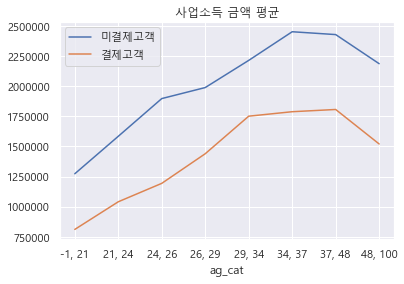

In [75]:
ag_p0=df.loc[df.income_사업.notnull(),:].query("has_paid==0").groupby('ag_cat')['income_사업'].mean()
ag_p0.name='미결제고객'
ag_p0.plot()
ag_p1=df.loc[df.income_사업.notnull(),:].query("has_paid==1").groupby('ag_cat')['income_사업'].mean()
ag_p1.name='결제고객'
ag_p1.plot()
plt.legend()
plt.title("사업소득 금액 평균")

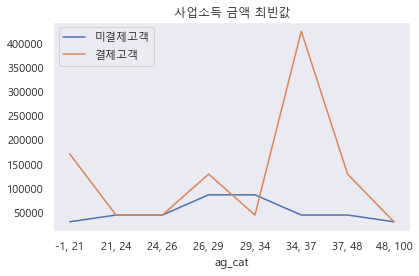

In [157]:
f1= lambda x: x.mode()
ag_p0=df.loc[df.income_사업.notnull(),:].query("has_paid==0").groupby('ag_cat')['income_사업'].agg(f1)
ag_p0.name='미결제고객'
ag_p0.plot()
ag_p1=df.loc[df.income_사업.notnull(),:].query("has_paid==1").groupby('ag_cat')['income_사업'].agg(f1)
ag_p1.name='결제고객'
ag_p1.plot()
plt.legend()
plt.title("사업소득 금액 최빈값")
plt.tight_layout()
plt.savefig('fig1.png', dpi=500)

#### 3-2)-(1)-1. 연령별 사업소득의 결제율을 높이기위한 값 설정
##### - 연령별 결제율
    사업소득을 일정금액 필터링하여 하기 전과 후의 차이를 살펴보기 위해 우선 나이대별 결제율을 구한다.

In [77]:
l1=[]
l2=[]
for i in df.ag_cat.unique():
    str_expr="ag_cat == @i"
    str_expr1="ag_cat == @i and has_paid ==1"
    l1.append(df.query(str_expr1).shape[0]/df.query(str_expr).shape[0])
    l2.append(i)
    
age_cvr=pd.DataFrame([l2,l1]).T
age_cvr.columns=['age_bin','cvr']
age_cvr=age_cvr.set_index('age_bin').sort_values('cvr',ascending=False)
age_cvr

,cvr
age_bin,
"-1, 21",0.663146
"21, 24",0.653823
"26, 29",0.653374
"24, 26",0.652258
"29, 34",0.638193
"37, 48",0.625418
"34, 37",0.621988
"48, 100",0.616695


<br></br>
##### - 사업소득 그룹화 (7개-> 6개와 null값)
    크기 순으로 17%씩 그룹을 나눠 사업소득 그룹을 설정한다.

In [78]:
inc_comp_cat=pd.cut(df.income_사업,bins=[-1,df.income_사업.quantile(0.17),df.income_사업.quantile(0.17*2),
                     df.income_사업.quantile(0.17*3),df.income_사업.quantile(0.17*4),df.income_사업.quantile(0.17*5),df.income_사업.max()])
      #l,abels=['a','b','c','d','e','f'])
df['inc_comp_cat']=inc_comp_cat
df['inc_comp_cat']=df['inc_comp_cat'].astype('str')
df['inc_comp_cat']=df['inc_comp_cat'].replace('nan','n')

##### - 사업소득 그룹별 결제율을 측정 (3번째로 낮은 수치의 사업소득그룹(295000.0, 640000.0]이 결제율은 높음)
    나이대별 결제율은 평균 64.06% 이므로 그보다 크게 높은 70%대의 결제율을 가진 사업소득그룹 중 최솟값(102,000)을  
    기준으로 필터링 후 나이대별 결제율 측정한다.

In [79]:
f1= lambda x : x/x.sum()
df.groupby(['inc_comp_cat','has_paid'])['refund'].count().unstack().apply(f1,axis=1).iloc[:,1].sort_values(ascending=False)

inc_comp_cat
(295000.0, 640000.0]       0.781172
(102000.0, 295000.0]       0.763988
(640000.0, 1233000.0]      0.746281
(1233000.0, 2793000.0]     0.704518
(-1.0, 102000.0]           0.642573
(2793000.0, 39934000.0]    0.605438
n                          0.420716
Name: 1, dtype: float64

##### - 필터링 후 나이대별 결제율을 필터링 전과 비교

In [80]:
l1=[]
l2=[]
for i in np.arange(0,ag_p1.shape[0]):
        l1.append(ag_p1.index[i])
        l2.append(df.query("income_사업>= 102000.0 and ag_cat==@ag_p1.index[@i]").has_paid.value_counts()[1]/df.query("income_사업>= 102000.0 and ag_cat==@ag_p1.index[@i]").shape[0])

age_mode_cvr=pd.DataFrame([l1,l2]).T
age_mode_cvr.columns=['age_bin','cvr']    
age_buis_cvr=age_mode_cvr.set_index('age_bin').sort_values('cvr',ascending=False)
age_buis_cvr['age_cvr']=age_cvr
age_buis_cvr

,cvr,age_cvr
age_bin,,
"26, 29",0.738617,0.653374
"34, 37",0.731175,0.621988
"29, 34",0.727812,0.638193
"24, 26",0.727063,0.652258
"21, 24",0.716702,0.653823
"37, 48",0.710381,0.625418
"-1, 21",0.702544,0.663146
"48, 100",0.697194,0.616695


In [81]:
(age_buis_cvr-age_cvr).mean()

age_cvr         NaN
cvr        0.078324
dtype: float64

- <U>사업소득에서 일반적인 결제율보다 높은 결제율을 보인 그룹의 최솟값을 기준으로 필터링하여 모든 연령대의 결제율이 평균 7.83%상승됨을 발견하였다.</U>  
#### 즉, 나이대별 사업소득 최빈값 그래프를 통해 가정한 '사업소득을 특정 값으로 필터링 할 경우, 결제율을 증가시킬 수 있을 것이다'라는  
#### 가정을 데이터를 통해 구매율이 증가하는 것(평균 64.06%->71.89%)을 통해 확인하였다. 
#### 그러므로, 자비스앤 빌런스에서는 사업소득이 102,000 이상인 고객에 대한 프로모션 마케팅이 필요할 것이다. 

***

#### 3-2)-(2) 기타소득 분석

In [82]:
df['기타yn']=df.기타yn.astype('str').replace('1','기').replace('0','no기')

In [83]:
kstest(df.has_paid[df.기타yn=='기'].dropna().values, "norm")

KstestResult(statistic=0.5018356407637132, pvalue=0.0)

- 콜모고로프 스미르노프 검정을 통해 정규성 검정을 했을 때 정규성이 충족하지 않는다. 그러므로 T검정이 아닌 만-휘트니U검정을 사용한다.

In [84]:
 mannwhitneyu(df.has_paid[df.기타yn=='기'],df.has_paid[df.기타yn=='no기'],alternative='two-sided')

MannwhitneyuResult(statistic=961314246.0, pvalue=7.953145555443032e-08)

- 비모수검정인 만휘트니U검정을 시행하면 p-value가 0.05보다 작다. 즉, 기타소득과 결제여부에 영향이 없다는 귀무가설이 기각된다.
- 그러므로 통계적으로는 <U>기타소득의 여부가 지불여부에 영향을 미치는 변수임을 확인할 수 있다.</U>

#### - 기타소득 그룹화

기타 소득의 경우도 사업소득과 같이 categorical value로 그룹화를 해서 분석을 진행한다.
- 결제 여부 그룹별 기타소득의 평균을 나이별로 선그래프로 그려보면 미결제 고객이 결제고객보다 높다.
- 다만, 이번에도 최빈값을 구하면 각 나이대별로 결제고객의 기타소득의 최빈값이 미결제고객보다 낮은 나이 구간은 없다.
- 그러므로, 기타소득의 경우에도 24-26세, 29-34세, 37-48세의 경우 일정금액 이상을 필터링하면 결제여부에 영향을 줄 수  
  것이라고 가정할 수 있다.

In [85]:
inc_etc_cat=pd.cut(df.income_기타,bins=[-1,df.income_기타.quantile(0.17),df.income_기타.quantile(0.17*2),
                     df.income_기타.quantile(0.17*3),df.income_기타.quantile(0.17*4),df.income_기타.quantile(0.17*5),df.income_기타.max()])

df['inc_etc_cat']=inc_etc_cat
df['inc_etc_cat']=df['inc_etc_cat'].astype('str')
df['inc_etc_cat']=df['inc_etc_cat'].replace('nan','n')

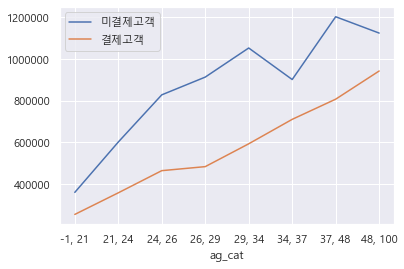

In [86]:
#기타소득 나이대별 평균
ag_p0=df.loc[df.income_기타.notnull(),:].query("has_paid==0").groupby('ag_cat')['income_기타'].mean()
ag_p0.name='미결제고객'
ag_p0.plot()
ag_p1=df.loc[df.income_기타.notnull(),:].query("has_paid==1").groupby('ag_cat')['income_기타'].mean()
ag_p1.name='결제고객'
ag_p1.plot()
plt.legend()

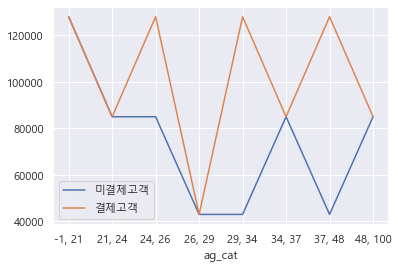

In [87]:
#기타소득 나이대별 최빈값
f1= lambda x: x.mode()[0]
ag_p0=df.loc[df.income_기타.notnull(),:].query("has_paid==0").groupby('ag_cat')['income_기타'].agg(f1)
ag_p0.name='미결제고객'
ag_p0.plot()
ag_p1=df.loc[df.income_기타.notnull(),:].query("has_paid==1").groupby('ag_cat')['income_기타'].agg(f1)
ag_p1.name='결제고객'
ag_p1.plot()
plt.legend()

- 사업소득이 있는 경우의 그룹별 결제율보다 기타소득이 있는 경우의 결제율이 전반적으로 낮은 경향이 있다.

In [88]:
f1= lambda x : x/x.sum()
df.groupby(['inc_etc_cat','has_paid'])['refund'].count().unstack().apply(f1,axis=1).iloc[:,1].sort_values(ascending=False)

inc_etc_cat
(51000.0, 114000.0]        0.690822
(114000.0, 213000.0]       0.688810
(-1.0, 51000.0]            0.686903
(213000.0, 425000.0]       0.682455
(425000.0, 1020000.0]      0.660925
n                          0.641813
(1020000.0, 62810000.0]    0.536968
Name: 1, dtype: float64

In [89]:
# 기타 소득 변수에 의한 필터링으로 나이대별 결제율 비교
l1=[]
l2=[]
for i in np.arange(0,ag_p1.shape[0]):
        l1.append(ag_p1.index[i])
        l2.append(df.query("income_기타>= 1 and ag_cat==@ag_p1.index[@i]").has_paid.value_counts()[1]/df.query("income_기타>= 1 and ag_cat==@ag_p1.index[@i]").shape[0])

age_mode_cvr=pd.DataFrame([l1,l2]).T
age_mode_cvr.columns=['age_bin','cvr']    
age_etc_cvr=age_mode_cvr.set_index('age_bin').sort_values('cvr',ascending=False)
age_etc_cvr['age_cvr']=age_cvr
age_etc_cvr.sort_index()

,cvr,age_cvr
age_bin,,
"-1, 21",0.682669,0.663146
"21, 24",0.648891,0.653823
"24, 26",0.648455,0.652258
"26, 29",0.667482,0.653374
"29, 34",0.646533,0.638193
"34, 37",0.671652,0.621988
"37, 48",0.70623,0.625418
"48, 100",0.641509,0.616695


- 기타 소득의 경우 그래프와 위치기준 기타소득범위를 고려해 17%의 값으로 필터링하거나 그래프에서 결제여부 그룹별로 구분이 되는 80000으로 필터링할 경우, 21세에서 26세까지의 그룹들의 결제율은 낮아지고 나머지 그룹은 결제율이 높아진다.
- 그러므로 그래프를 보고 가정한 기타 소득기반의 필터링은 26세 이상의 나이대 그룹과 21세이하 나이대의 그룹에만 해당된다.
- <U>즉, 필터링 없는 경우와 비교하면  '26세 이상의 나이대 그룹'에게 기타소득 기반 필터링을 하는 것이 결제에 영향을 준다.</U> 

***

#### 3-2)-(3) 근로소득 분석
    - 통계적으로 근로소득이 결제여부에 영향을 미치는지 확인

In [90]:
df['근로yn']=df.근로yn.astype('str').replace('1','근').replace('0','no근')

In [91]:
kstest(df.has_paid[df.근로yn=='근'].dropna().values, "norm")

KstestResult(statistic=0.5408617963982725, pvalue=0.0)

- 콜모고로프 스미르노프 검정을 통해 정규성 검정을 했을 때 정규성이 충족하지 않는다. 그러므로 T검정이 아닌 만-휘트니U검정을 사용한다.

In [92]:
 mannwhitneyu(df.has_paid[df.근로yn=='근'],df.has_paid[df.근로yn=='no근'],alternative='two-sided')

MannwhitneyuResult(statistic=1315189860.0, pvalue=4.300327594584027e-186)

- 비모수검정인 만휘트니U검정을 시행하면 p-value가 0.05보다 작다. 즉, 근로소득과 결제여부에 영향이 없다는 귀무가설이 기각된다.
- 그러므로 통계적으로는 <U>근로소득의 여부가 지불여부에 영향을 미치는 변수임을 확인할 수 있다.</U>

#### - 근로소득 범주화
    근로소득의 경우에도 특정 값으로 필터링 하는 것이 각 나이대 그룹별 결제율의 상승에 영향을 주는지 파악해 보겠다.

In [93]:
inc_lab_cat=pd.cut(df.income_근로,bins=[-1,df.income_근로.quantile(0.17),df.income_근로.quantile(0.17*2),
                     df.income_근로.quantile(0.17*3),df.income_근로.quantile(0.17*4),df.income_근로.quantile(0.17*5),df.income_근로.max()])
      #l,abels=['a','b','c','d','e','f'])
df['inc_lab_cat']=inc_lab_cat
df['inc_lab_cat']=df['inc_lab_cat'].astype('str')
df['inc_lab_cat']=df['inc_lab_cat'].replace('nan','n')

In [94]:
f1= lambda x : x/x.sum()
df.groupby(['inc_lab_cat','has_paid'])['refund'].count().unstack().apply(f1,axis=1).iloc[:,1].sort_values(ascending=False)

inc_lab_cat
(4651000.0, 7742000.0]       0.712329
(2457600.0, 4651000.0]       0.706561
(-1.0, 993300.0]             0.702523
(993300.0, 2457600.0]        0.700750
(7742000.0, 12228500.0]      0.698399
(12228500.0, 182335000.0]    0.673476
n                            0.610016
Name: 1, dtype: float64

In [95]:
# 근로 소득 카테고리에서 최소값기준으로 필터링하여 결제율 비교
l1=[]
l2=[]
for i in np.arange(0,ag_p1.shape[0]):
        l1.append(ag_p1.index[i])
        l2.append(df.query("income_근로>= 1 and ag_cat==@ag_p1.index[@i]").has_paid.value_counts()[1]/df.query("income_근로>= 1 and ag_cat==@ag_p1.index[@i]").shape[0])

age_mode_cvr=pd.DataFrame([l1,l2]).T
age_mode_cvr.columns=['age_bin','cvr']    
age_lab_cvr=age_mode_cvr.set_index('age_bin').sort_values('cvr',ascending=False)
age_lab_cvr['age_cvr']=age_cvr
age_lab_cvr.sort_index()

,cvr,age_cvr
age_bin,,
"-1, 21",0.674883,0.663146
"21, 24",0.692552,0.653823
"24, 26",0.703427,0.652258
"26, 29",0.705387,0.653374
"29, 34",0.69557,0.638193
"34, 37",0.698121,0.621988
"37, 48",0.708914,0.625418
"48, 100",0.697551,0.616695


In [96]:
(age_lab_cvr['cvr']-age_lab_cvr['age_cvr']).mean()

0.05643869501667814

- 근로소득은 존재 여부의 필터링만이라도 모든 연령층에서 결제율 전환을 상승을 관찰할 수 있으며 17%로 필터링하면 더 작게 상승한다.
- 그러므로, <U>근로소득도 결제여부에 영향을 주는 변수라고 볼 수 있다.</U>
- 다만 차이값의 평균으로 보면 3가지 소득에서 사업 > 근로 > 기타 순으로 결제여부에 영향을 주는 것으로 볼 수 있다.

***

### 4. AGE 변수 분석 

#### 4-1) 통계적 방법으로 나이 그룹별 결제율의 차이가 유의한지 확인

##### 나이그룹별 결제 데이터(1)와 미결제데이터(0)의 교차집계표 생성
    아래에서 보는것 처럼 나이대 별로 결제 여부에 대한 교차집계표를 그릴수 있으며 결제율도 구할 수 있다.
    결제율의 경우 21세이하가 66.314%로 1등이며 48세초과 그룹이 61.669%로 꼴지이다. 
    이러한 차이가 유의한 차이인지 카이제곱검정을 시행해 보겠다.(이를 독립성 검정이라고도 부른다.)

In [97]:
# 교차집계표(cross table)
df.groupby(['ag_cat','has_paid'])['year'].count().unstack()

has_paid,0,1
ag_cat,,
"-1, 21",2456,4835
"21, 24",7439,14050
"24, 26",6275,11770
"26, 29",7423,13992
"29, 34",5502,9705
"34, 37",1757,2891
"37, 48",2912,4862
"48, 100",1575,2534


In [98]:
# 나이 그룹별 결제율
age_cvr

,cvr
age_bin,
"-1, 21",0.663146
"21, 24",0.653823
"26, 29",0.653374
"24, 26",0.652258
"29, 34",0.638193
"37, 48",0.625418
"34, 37",0.621988
"48, 100",0.616695


(0.5, 0.8)

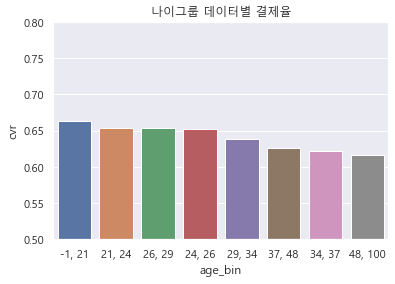

In [99]:
# 나이 그룹별 결제율 시각화
plt.rcParams['font.family'] = 'Malgun Gothic'
sns.barplot(x=age_cvr.index,y=age_cvr.cvr)
plt.title('나이그룹 데이터별 결제율')
plt.ylim(0.5, 0.8)

- 독립성 검정은  두 factor 변수사이에 '귀무가설 : 독립이다. / 대립가설 : 독립이 아니다.' 를 의미한다.
- 카이제곱검정을 통한 P_value가 0.05보다 작으면 귀무가설은 기각되고 대립가설이 채택된다.  
- 주어진 데이터에서 나이카테고리와 지불여부에 대한 독립성검정시 pvalue가 0.05보다 작아 대립가설이 채택되고 서로 관련이 있다고 볼 수 있다.  
- 즉, 통계적으로 <U>나이가 결제여부에 영향을 준다고 볼 수 있다.</U>

In [100]:
# 독립성검정
from scipy.stats import chi2_contingency
df_age=pd.crosstab(df.ag_cat,df.has_paid)
p_value=chi2_contingency(df_age,correction=False)[1]
(p_value,p_value<0.05)

(2.5428346424485214e-12, True)

#### 4-2) 데이터 그룹별 결제수 합과 결제율을 비교

- 나이대별 결제율의 차이가 통계적으로 유의함이 증명되었고, 나이대별로 결제 데이터 수의 규모도 살펴보겠다.
- 21-24세, 26-29세가 가장 결제 규모가 높고 34세까지는 높은 편에 속한다.
- age_cvr은 위에서 만든 나이별 전체 데이터의 결제율데이터이다.
- 결제율은 20세 이하의 데이터가 1등이기 때문에, 결제 규모의 순위와는 차이가 있다고 볼 수 있다.
- 하지만, 결제율과 규모 모두 34세 이상의 나이가 하위권이고 그 이전의 나이대는 상위권인것처럼 전체적인 추세는 비슷하다.
- <U>결국 34세 이하의 연령에 해당하는지의 여부가 결제여부에 영향을 미치는 것으로 볼 수 있다.</U>

In [101]:
# 나이대별 결제 데이터 수의 합을 보기 위한 것이다.
a=df.groupby('ag_cat')['has_paid'].sum().sort_values(ascending=False)
a

ag_cat
21, 24     14050
26, 29     13992
24, 26     11770
29, 34      9705
37, 48      4862
-1, 21      4835
34, 37      2891
48, 100     2534
Name: has_paid, dtype: int32

Text(0.5, 1.0, '나이대별 결제 데이터수의 합')

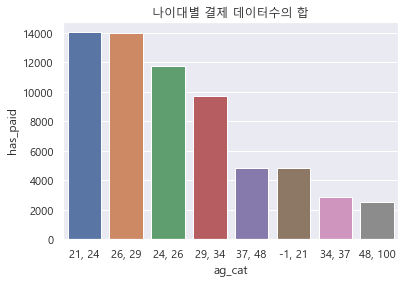

In [102]:
sns.barplot(x=a.index,y=a)
plt.title('나이대별 결제 데이터수의 합')

- 결제율과 나이대별 결제 규모를 고려한 변수 생성( 결제규모 x 결제율)
- 변수의 값을 보면, 34세 이전에 해당하는 그룹의 값과 아닌값의 차이가 약 2배 넘게 차이난다.
- 즉, <U>특정 연령 그룹에 해당하는지의 여부가 결제여부에 영향을 주는 것으로 파악된다.</U>

#### 나이가 결제금액에 영향을 미치는지 파악

In [103]:
# 나이대별 결제금액의 평균
a1=df.groupby('ag_cat')['Target'].mean()

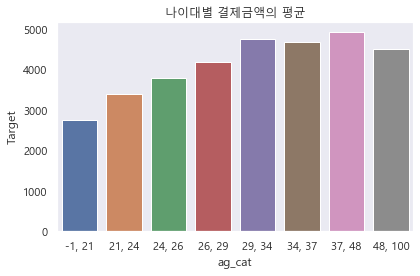

In [159]:
sns.barplot(x=a1.index,y=a1)
plt.title("나이대별 결제금액의 평균")
plt.tight_layout()
plt.savefig('fig1.png', dpi=900)

- 나이대별로 결제금액의 평균을 구하면 상당히 차이가 있는데 이 차이가 통계적으로 유의한지 확인한다.

- 정규성검정  
    모든 나이대의 그룹에 대해 콜모고로프 스미르노프 검정으로 정규성 검정을 수행했고 pvalue가 0.05보다 작아 정규성을 충족하지 않았음을 확인했다.

In [105]:
kstest(df.Target[df.ag_cat=='29, 34'].dropna().values, "norm")

KstestResult(statistic=0.6381929374630104, pvalue=0.0)

In [106]:
kstest(df.Target[df.ag_cat=='26, 29'].dropna().values, "norm")

KstestResult(statistic=0.6533738034088257, pvalue=0.0)

In [107]:
kstest(df.Target[df.ag_cat=='37, 48'].dropna().values, "norm")

KstestResult(statistic=0.6254180602006689, pvalue=0.0)

In [108]:
kstest(df.Target[df.ag_cat=='24, 26'].dropna().values, "norm")

KstestResult(statistic=0.6522582432806872, pvalue=0.0)

In [109]:
kstest(df.Target[df.ag_cat=='48, 100'].dropna().values, "norm")

KstestResult(statistic=0.616695059625213, pvalue=0.0)

In [110]:
kstest(df.Target[df.ag_cat=='21, 24'].dropna().values, "norm")

KstestResult(statistic=0.6538228861277864, pvalue=0.0)

In [111]:
kstest(df.Target[df.ag_cat=='34, 37'].dropna().values, "norm")

KstestResult(statistic=0.6219879518072289, pvalue=0.0)

In [112]:
kstest(df.Target[df.ag_cat=='-1, 21'].dropna().values, "norm")

KstestResult(statistic=0.6631463448086683, pvalue=0.0)

In [113]:
a=df.Target[df.ag_cat=='29, 34']
b= df.Target[df.ag_cat=='26, 29']
c= df.Target[df.ag_cat=='37, 48']
d=df.Target[df.ag_cat=='24, 26']
e=df.Target[df.ag_cat=='48, 100']
f=df.Target[df.ag_cat=='21, 24']
g=df.Target[df.ag_cat=='34, 37']
h=df.Target[df.ag_cat=='-1, 21']

- 등분산성 검정
    그룹간 평균의 차이가 있는지 확인하기 위하여 ANOVA검정을 수행하기 위해서는 등분산성을 만족하여야 한다.  
    bartlett검정을 통해 나이 그룹간에는 등분산성을 충족하지 않음을 확인했다.
    그러므로, 

In [114]:
bartlett(a,b,c,d,e,f,g,h)

BartlettResult(statistic=4831.8021803484835, pvalue=0.0)

 ##### 정규성과 등분산성 가정을 만족하지 않고 표본집단이 3개 이상이므로  Kruskal-Wallis test를 진행한다.
 - H0 : 모든 소득원 그룹의 중위수가 같다. vs  H1 : 최소 한 그룹의 중위수가 다르다.

In [115]:
kruskal(a,b,c,d,e,f,g,h)

KruskalResult(statistic=86.60092303067619, pvalue=6.161844373601541e-16)

- 크루스칼왈리스검정의 p-value 값이 0.05보다 작으면 통계적으로 유의미한 차이가 있다는 의미이다. 귀무가설이 기각되고 대립가설이 채택된다.
- 최종적으로 정리하면, <U>나이 변수는 결제여부에 차이를 주고 영향이 있다고 볼 수 있다.</U>

***

### 5. refund 와 fee 변수 분석 
#### 5-1) refund 변수 분석
- 환불액을 3가지 범주 데이터로 변환

In [116]:
df=df.sort_values(by='refund')
l1=[]
for i in range(df.shape[0]):
    if i > df.shape[0]*0.66:
        l1.append('a')
    elif i > df.shape[0]*0.33:
        l1.append('b')
    else:
        l1.append('c')

df['ref_cat']=l1
df['ref_cat']

98352    c
52858    c
55168    c
54256    c
94281    c
        ..
30513    a
2374     a
47635    a
11235    a
61745    a
Name: ref_cat, Length: 99978, dtype: object

- 환불액 그룹별 결제 여부 교차집계표(cross table)  
    b그룹이 a그룹보다 결제율이 9%높고, c그룹 보다는 5%높다. 이러한 차이가 통계적으로 유의할지 확인해본다.

In [117]:
f1= lambda x: x/x.sum()
df.groupby(['ref_cat','has_paid'])['age'].count().unstack().apply(f1,axis=1)

has_paid,0,1
ref_cat,,
a,0.391592,0.608408
b,0.308247,0.691753
c,0.359410,0.640590


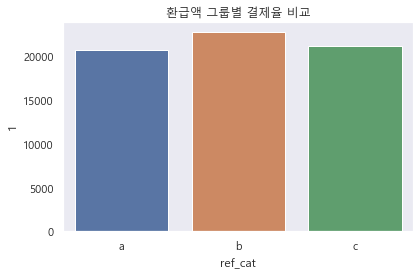

In [160]:
sns.barplot(x=df.groupby(['ref_cat','has_paid'])['age'].count().unstack().apply(f1,axis=1).index,y=df.groupby(['ref_cat','has_paid'])['age'].count().unstack().apply(f1,axis=1).loc[:,1])
plt.title("환급액 그룹별 결제율 비교")
plt.tight_layout()
plt.savefig('fig1.png', dpi=900)

- 환급액 그룹과 결제여부에 대한 독립성 검증 수행

In [119]:
from scipy.stats import chi2_contingency
df_tempt=pd.crosstab(df.ref_cat,df.has_paid)
p_value=chi2_contingency(df_tempt,correction=False)[1]
(p_value,p_value<0.05)

(6.918925906062657e-113, True)

In [162]:
kruskal(df.Target[df.ref_cat=='a'],df.Target[df.ref_cat=='b'],df.Target[df.ref_cat=='c'])

KruskalResult(statistic=12766.191062230346, pvalue=0.0)

- 독립성검정에 의하면, 예상 환급액 그룹별로 결제율의 차이는 유의한 것으로 판단된다.
- 즉, 통계적으로는 예상 환급액은 결제여부에 영향을 준다.(참고로 xgboost 분류모델에서 feature importacne 순위에서도 상위에 있었다.)

#### 위 통계적 근거를 바탕으로 가장 결제율이 높은 b그룹의 환급액을 기준으로 필터링을 하여 결제율 개선을 확인해 보겠다.

- 연령 데이터에서 b 그룹에 해당하는 refund 값으로 필터링하여 전체 연령 그룹의 결제율 개선확인(평균 약 4.47%의 향상)
- <U> 즉, '환급액은 결제 여부에 영향을 미친다.'</U>는 것을 다시 확인할 수 있다.

In [120]:
l1=[]
l2=[]
for i in np.arange(0,ag_p1.shape[0]):
        l1.append(ag_p1.index[i])
        l2.append(df.query("refund >= 48000 and refund <= 180000 and ag_cat==@ag_p1.index[@i]").has_paid.value_counts()[1]/df.query("refund >= 48000 and refund <= 180000 and ag_cat==@ag_p1.index[@i]").shape[0])

age_mode_cvr=pd.DataFrame([l1,l2]).T
age_mode_cvr.columns=['age_bin','cvr']    
age_ref_cvr=age_mode_cvr.set_index('age_bin').sort_values('cvr',ascending=False)
age_ref_cvr['age_cvr']=age_cvr
age_ref_cvr.sort_index()

,cvr,age_cvr
age_bin,,
"-1, 21",0.731395,0.663146
"21, 24",0.703872,0.653823
"24, 26",0.694764,0.652258
"26, 29",0.69403,0.653374
"29, 34",0.668028,0.638193
"34, 37",0.650507,0.621988
"37, 48",0.676407,0.625418
"48, 100",0.663415,0.616695


Text(0.5, 1.0, '나이대별 환급세액 필터링 여부에 따른 결제율 비교')

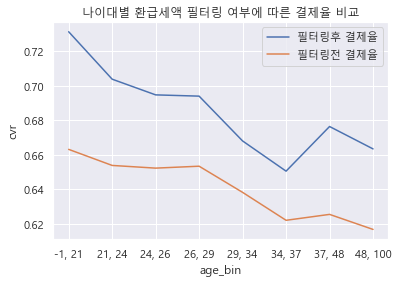

In [121]:
sns.lineplot(x=age_ref_cvr.sort_index().index,y=age_ref_cvr.sort_index().loc[:,'cvr'],label='필터링후 결제율')
sns.lineplot(x=age_ref_cvr.sort_index().index,y=age_ref_cvr.sort_index().loc[:,'age_cvr'],label='필터링전 결제율')
plt.title("나이대별 환급세액 필터링 여부에 따른 결제율 비교")

In [122]:
# 환급금액 필터링을 통한 결제율 향상 평균
(age_ref_cvr['cvr']-age_lab_cvr['age_cvr']).mean()

0.04469038955781765

#### 5-2) fee 변수 분석
    fee의 경우에는 refund처럼 그룹을 크게 나눌 경우 일부 나이대 구간에서 결제율이 감소하는 경향이 나타나 더 세세하게 나누었다. 

In [123]:
df=df.sort_values(by='fee')
l1=[]
for i in range(df.shape[0]):
    if i > df.shape[0]*0.90:
        l1.append('a')
    elif i > df.shape[0]*0.80:
        l1.append('b')
    elif i > df.shape[0]*0.70:
        l1.append('c')
    elif i > df.shape[0]*0.60:
        l1.append('d')
    elif i > df.shape[0]*0.50:
        l1.append('e')
    elif i > df.shape[0]*0.40:
        l1.append('f')
    elif i > df.shape[0]*0.30:
        l1.append('g')
    elif i > df.shape[0]*0.20:
        l1.append('h')
    elif i > df.shape[0]*0.10:
        l1.append('i')
    else:
        l1.append('j')

df['f_cat']=l1
df['f_cat']

11627    j
46540    j
21086    j
58364    j
37554    j
        ..
30513    a
2374     a
47635    a
11235    a
61745    a
Name: f_cat, Length: 99978, dtype: object

- 각 수수료 그룹별 결제율 교차표

In [124]:
f1= lambda x: x/x.sum()
df.groupby(['f_cat','has_paid'])['age'].count().unstack().apply(f1,axis=1).sort_values(by=1,ascending=False)

has_paid,0,1
f_cat,,
e,0.263779,0.736221
j,0.291158,0.708842
i,0.297660,0.702340
f,0.304361,0.695639
c,0.323365,0.676635
g,0.364673,0.635327
b,0.375075,0.624925
d,0.379576,0.620424
h,0.417183,0.582817


Text(0.5, 1.0, '수수료 그룹별 결제율 비교')

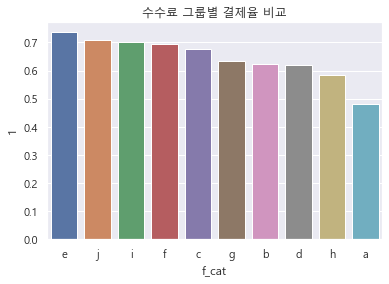

In [125]:
plt.rcParams['font.family'] = 'Malgun Gothic'
sns.barplot(x=df.groupby(['f_cat','has_paid'])['age'].count().unstack().apply(f1,axis=1).sort_values(by=1,ascending=False).index,y=df.groupby(['f_cat','has_paid'])['age'].count().unstack().apply(f1,axis=1).loc[:,1].sort_values(ascending=False))
plt.title("수수료 그룹별 결제율 비교")

- 카이제곱검정을 수행하고 p_value가 유의수준인 0.05보다 작으므로 수수료가 결제여부에 독립이 아니라는 것을 확인하였다.

In [126]:
from scipy.stats import chi2_contingency
df_tempt=pd.crosstab(df.f_cat,df.has_paid)
p_value=chi2_contingency(df_tempt,correction=False)[1]
(p_value,p_value<0.05)

(0.0, True)

In [163]:
kruskal(df.has_paid[df.f_cat=='a'],df.has_paid[df.f_cat=='b'],df.has_paid[df.f_cat=='c'],df.has_paid[df.f_cat=='d'],df.has_paid[df.f_cat=='e'],df.has_paid[df.f_cat=='f'],df.has_paid[df.f_cat=='g'],df.has_paid[df.f_cat=='h'])

KruskalResult(statistic=1803.7648617507343, pvalue=0.0)

- 결제율이 70%대인 수수료 그룹중 가장 낮은 결제율 그룹인 i 그룹의 수수료와 나이별 결제율이 대부분 63%대 이므로 수수료그룹별 결제율에서 62%대로 떨어지는 수수료그룹중 가장 큰 값인 b를 기준으로 필터링을 진행를 기준으로 필터링을 진행하였다.

In [168]:
(df.fee[df.f_cat=='i'].min(),df.fee[df.f_cat=='b'].max())

(400.0, 20800.0)

In [167]:
l1=[]
l2=[]
for i in np.arange(0,ag_p1.shape[0]):
        l1.append(ag_p1.index[i])
        l2.append(df.query("fee >= 400 and fee <= 20800 and ag_cat==@ag_p1.index[@i]").has_paid.value_counts()[1]/df.query("fee >= 400 and fee <= 20800 and ag_cat==@ag_p1.index[@i]").shape[0])

age_mode_cvr=pd.DataFrame([l1,l2]).T
age_mode_cvr.columns=['age_bin','cvr']    
age_ref_cvr=age_mode_cvr.set_index('age_bin').sort_values('cvr',ascending=False)
age_ref_cvr['age_cvr']=age_cvr
age_ref_cvr.sort_index()

,cvr,age_cvr
age_bin,,
"-1, 21",0.676547,0.663146
"21, 24",0.671107,0.653823
"24, 26",0.673346,0.652258
"26, 29",0.671841,0.653374
"29, 34",0.654661,0.638193
"34, 37",0.636275,0.621988
"37, 48",0.64325,0.625418
"48, 100",0.637171,0.616695


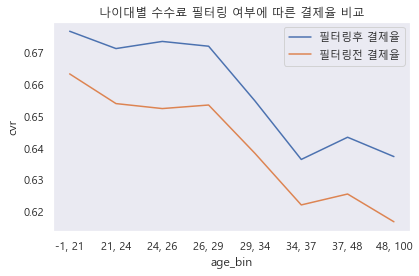

In [169]:
sns.lineplot(x=age_ref_cvr.sort_index().index,y=age_ref_cvr.sort_index().loc[:,'cvr'],label='필터링후 결제율')
sns.lineplot(x=age_ref_cvr.sort_index().index,y=age_ref_cvr.sort_index().loc[:,'age_cvr'],label='필터링전 결제율')
plt.title("나이대별 수수료 필터링 여부에 따른 결제율 비교")
plt.tight_layout()
plt.savefig('fig1.png', dpi=600)

#### 모든 연령층에서 이전보다 결제율이 상승되었음이 발견되었고, 이로 인해 수수료가 결제여부에 영향을 준다는 것을 알 수 있다.

##### 각 그룹별 Target의 평균
- 환급액 그룹

Text(0.5, 1.0, '환급액그룹별 결제금액의 평균')

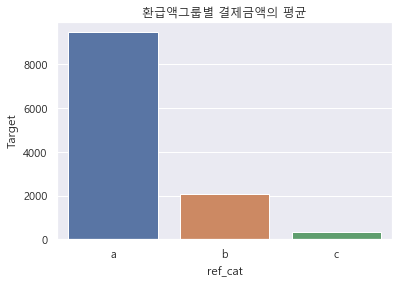

In [130]:
sns.barplot(x=df.groupby('ref_cat')['Target'].mean().index,y=df.groupby('ref_cat')['Target'].mean())
plt.title("환급액그룹별 결제금액의 평균")

- 수수료 그룹

Text(0.5, 1.0, '수수료 그룹별 결제금액의 평균')

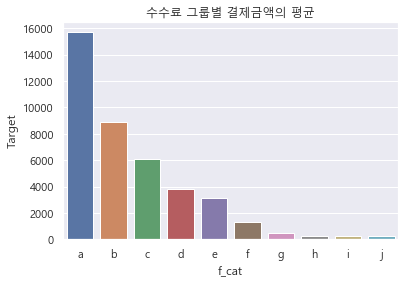

In [131]:
sns.barplot(x=df.groupby('f_cat')['Target'].mean().index,y=df.groupby('f_cat')['Target'].mean())
plt.title("수수료 그룹별 결제금액의 평균")

- 위 그래프에서 보는 것처럼 수수료와 환급액은 Target('결제한 고객의 수수료')과 양의 상관관계를 가진 변수로 환급세액이나 수수료나 A그룹이 결제금액의 평균이 제일 크고 알파벳순으로 순위가 이어지는 것을 보면 <U>환불세액과 수수료가 결제여부에는 영향을 주더라도 결제금액의 합을 증대시키는 방안을 찾는 것에는 크게 의미가 없다고 생각한다.</U>

***

### 6.  year변수분석과 결제금액 총합계 증대방안
#### 6-1)  연도에 따른 변화 분석

- 주어진 데이터에서는 다음의 특이사항이 있다.
- 19년 이전까지는 연별 결제율이 감소하긴하였으나, 특히 20년에 급감했다.
- 19년도 까지는 연도가 지나면서 결제 규모(결제데이터수)가 증가했으나 20년에 급감했다. 반면, 미결제 데이터 결제 규모는 19년까지 쭉  
  증가하다가 20년도에 급증했다.
- 연도별 총 유입의 증가폭은 2019년까지 감소하다가 20년에 반등했다.
- 20년도는 미결제 데이터의 수는 금증하고 결제 데이터는 급감하였다.
- 19년부터 20년사이에 결제데이터의 수가 감소하고 예상환불액합계는 오히려 미결제자 측에서 급격히 증가하는 등 추세가 최근에 변하였다.

In [132]:
# 년도별 결제율 출력
l1=[]
l2=[]
for i in df.year.unique():
    str_expr="year == @i"
    str_expr1="year == @i and has_paid ==1"
    l1.append(df.query(str_expr1).shape[0]/df.query(str_expr).shape[0])
    l2.append(i)
    
y_cvr=pd.DataFrame([l2,l1]).T
y_cvr.columns=['year','cvr']
y_cvr=y_cvr.set_index('year').sort_values('cvr',ascending=False)
y_cvr

,cvr
year,
2015.0,0.711307
2017.0,0.697633
2016.0,0.697124
2018.0,0.695115
2019.0,0.694999
2020.0,0.485241


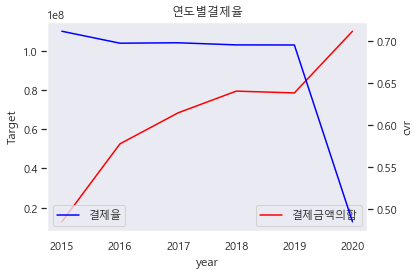

In [172]:
import warnings
warnings.filterwarnings(action='ignore')
plt.rcParams['font.family'] = 'Malgun Gothic'

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
sns.lineplot(df.groupby('year')['Target'].sum().index,df.groupby('year')['Target'].sum(),label='결제금액의합',ax=ax1,color='red')
sns.lineplot(y_cvr.index,y_cvr['cvr'],label='결제율',ax=ax2,color='blue')
ax1.legend(loc="lower right")
ax2.legend()
plt.title("연도별결제율")
plt.tight_layout()
plt.savefig('fig1.png', dpi=600)

- 결제데이터가 급격히 줄고, 미결제 데이터가 급격히 늘었으니 위 그래프 처럼 결제율이 급락하는 것은 당연하다.

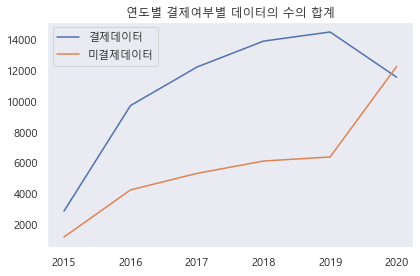

In [171]:
warnings.filterwarnings(action='ignore')

df_y_hp=df.groupby(['year','has_paid'])['age'].count()
df_y_hp.name='count'
df_y_hp=df_y_hp.reset_index()
df_y_hp1=df_y_hp.query("has_paid==1")
df_y_hp0=df_y_hp.query("has_paid==0")
plt.plot(df_y_hp1.year,df_y_hp1['count'],label='결제데이터')
plt.plot(df_y_hp0.year,df_y_hp0['count'],label='미결제데이터')
plt.legend()
plt.title('연도별 결제여부별 데이터의 수의 합계')
plt.tight_layout()
plt.savefig('fig1.png', dpi=600)

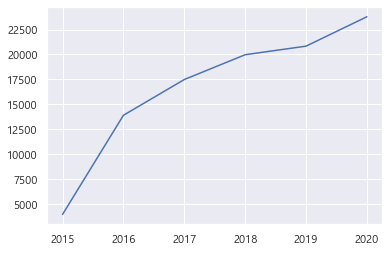

In [135]:
#연도별 총 유입의 증가폭
plt.plot(df.groupby('year')['age'].count().index,df.groupby('year')['age'].count())

In [136]:
#연도별 총 유입의 증가율
df.groupby('year')['age'].count().pct_change()

year
2015         NaN
2016    2.494975
2017    0.257513
2018    0.142122
2019    0.042947
2020    0.141390
Name: age, dtype: float64

- 이러한 결제고객의 감소가 고객들의 순 환급액의 감소 때문이 아닐까 추정되어 이를 살펴보면 오히려 순환급액은 증가한다.
- 순환급액 때문에 2020년에 결제고객과 결제율이 급감한 것은 아니다.

Text(0.5, 1.0, '연도별 결제여부별 환급액의 평균')

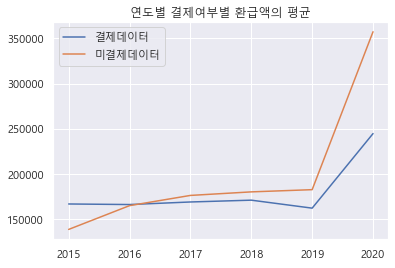

In [137]:
plt.plot(df.query("has_paid==1").groupby('year')['refund'].sum().index,df.query("has_paid==1").groupby('year')['gain'].mean(),label='결제데이터')
plt.plot(df.query("has_paid==0").groupby('year')['refund'].sum().index,df.query("has_paid==0").groupby('year')['gain'].mean(),label='미결제데이터')
plt.legend()
plt.title('연도별 결제여부별 환급액의 평균')

- 고객당 매출기여도(결제금액의 평균)는 20년도에 급격히 증가한다. 또한 총 고객의 연도별 결제금액의 합(연매출액)도 크게 증가한다.  
( 결제율과 결제고객수는 줄었는데, 고객 당 서비스를 통해 얻는 이익과 회사에 기여하는 평균 결제액, 총 결제액은 증가하였다.)

Text(0.5, 1.0, '연도별 결제고객별 결제금액의 평균값')

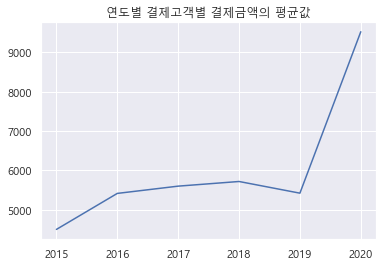

In [138]:
plt.plot(df.query("has_paid==1").groupby('year')['Target'].sum().index,df.query("has_paid==1").groupby('year')['Target'].mean(),label='결제데이터')
plt.title('연도별 결제고객별 결제금액의 평균값')

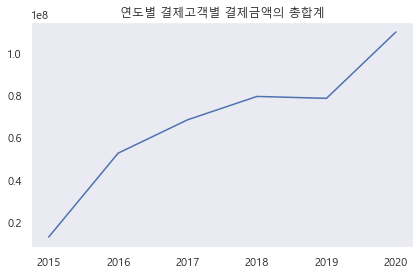

In [173]:
plt.plot(df.query("has_paid==1").groupby('year')['Target'].sum().index,df.query("has_paid==1").groupby('year')['Target'].sum(),label='결제데이터')
plt.title('연도별 결제고객별 결제금액의 총합계')
plt.tight_layout()
plt.savefig('fig1.png', dpi=600)

In [140]:
# 전년대비 결제금액의 총합계 증가율
df.query("has_paid==1").groupby('year')['Target'].sum().index,df.query("has_paid==1").groupby('year')['Target'].sum().pct_change()

(Int64Index([2015, 2016, 2017, 2018, 2019, 2020], dtype='int64', name='year'),
 year
 2015         NaN
 2016    3.123130
 2017    0.301403
 2018    0.162067
 2019   -0.011429
 2020    0.400863
 Name: Target, dtype: float64)

#### 위와 같은 사실로 다음의 아이디어를 도출할 수 있다.
- 미결제 데이터의 수(높아짐)와 결제 데이터의 수(낮아짐)가 20년도에 교차되고 결제율이 급락하더라도 결제 금액총합은 지속적으로 증가했다.  
    -> 결제금액의 총합은 16년을 제외하면 2020년에 전년대비 증가 비율이 가장 높다.  
    -> 즉, 이전년도와 비교하여 20년도의 어떠한 변화가 있었는지를 통해 결제율과 상관없이 총결제금액의 증대 방안을 유추할 수 있을 것이다.  
    -> 이하에서는 년도별로 각 변수들의 변화를 살펴보고 이로 인하여 결제금액이 증대되는지 살펴보겠다.

#### 6-2) 2020년에 발생한 특이 사항 확인
- 년도별 사업소득 그룹별로 차지하는 비중의 변화를 살펴보겠다.

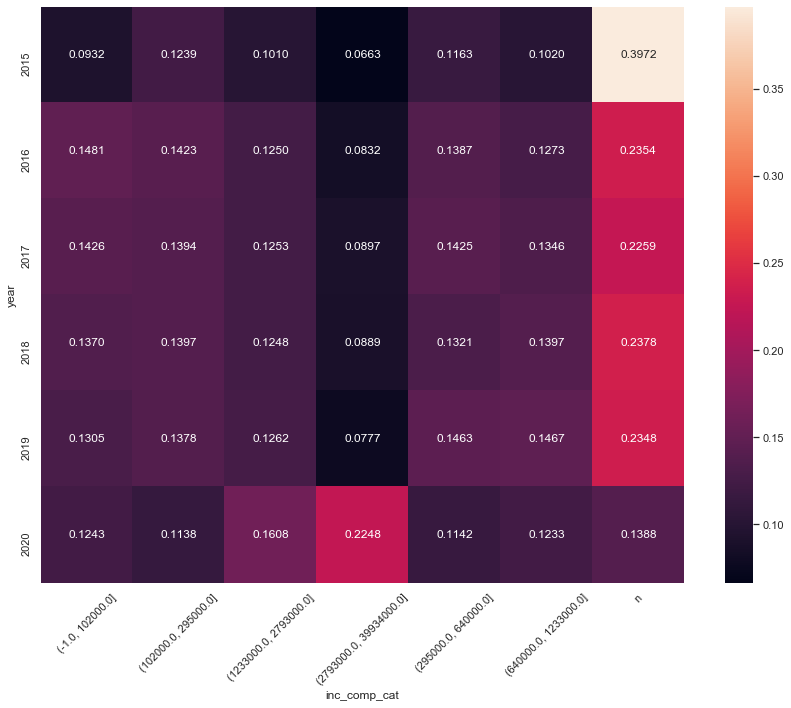

In [174]:
plt.rc('font', family='Malgun Gothic')
f1= lambda x: x / x.sum() 
tab=pd.crosstab(df.year,df.inc_comp_cat).apply(f1,axis=1)
sns.set(style='darkgrid')
plt.figure(figsize=(12,10))
ax=sns.heatmap(tab,annot=True,fmt='.04f')
ax.set_ylim(6,0)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('fig1.png', dpi=400)


- 세로축을 보면 20년이되어, 사업소득이 없는 데이터(n)가 23%대에서 13%대로 급감하고, 사업소득이 2백79만3천원 에서  
  3천9백93만4천원 범위인 데이터의 전체에서의 비중이 6~8%대에서 22%로 급격하게 상승했다.
- 그외, 사업 소득이 1233000에서 2793000까지에 속한 그룹의 데이터 비중도 증가하는 등 사업소득 그룹의 구성비중에 변화가 있었다.

#### 년도별 근로소득과 기타소득 그룹별로 차지하는 비중의 변화를 살펴보겠다.

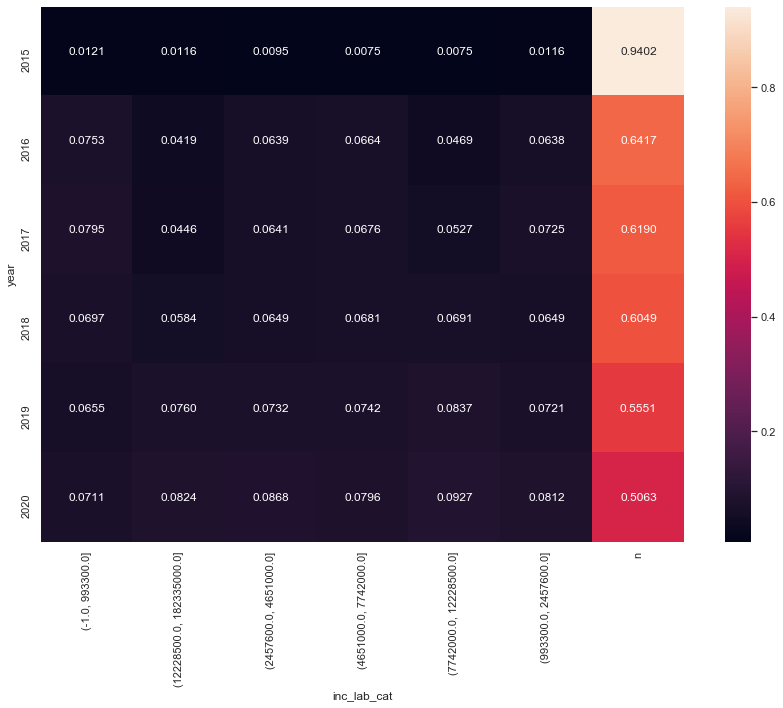

In [175]:
tab=pd.crosstab(df.year,df.inc_lab_cat).apply(f1,axis=1)
sns.set(style='dark')
plt.figure(figsize=(12,10))
ax=sns.heatmap(tab,annot=True,fmt='.04f')
ax.set_ylim(6,0)
plt.tight_layout()
plt.savefig('fig1.png', dpi=400)

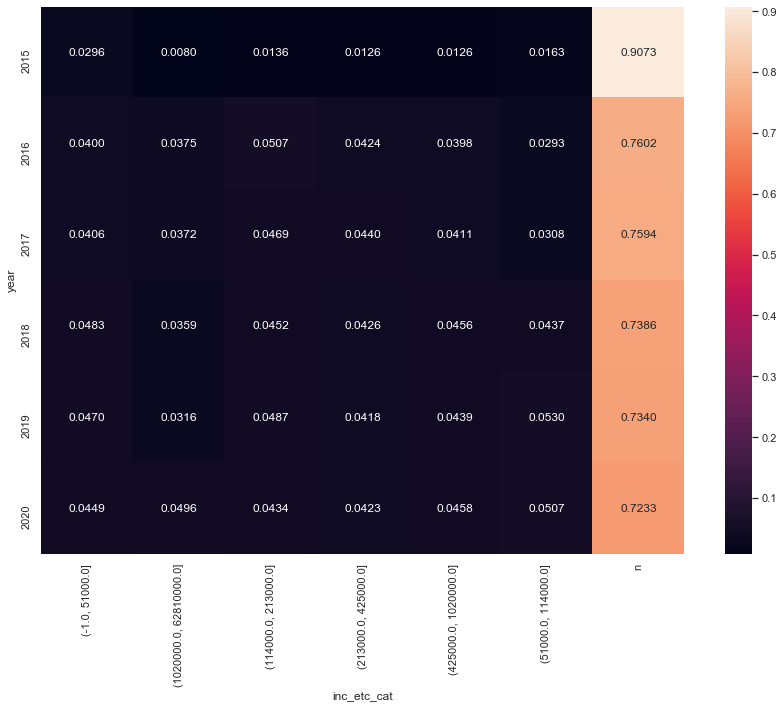

In [176]:
tab=pd.crosstab(df.year,df.inc_etc_cat).apply(f1,axis=1)
sns.set(style='dark')
plt.figure(figsize=(12,10))
ax=sns.heatmap(tab,annot=True,fmt='.04f')
ax.set_ylim(6,0)
plt.tight_layout()
plt.savefig('fig1.png', dpi=400)

- 근로소득의 경우나 기타소득의 경우에는 이에 비해 결측값 감소나 특정그룹의 비율 변화정도가 작은편이다.

#### 년도별 세액환급액(refund) 그룹별(a,b,c)로 차지하는 비중의 변화를 살펴보겠다.

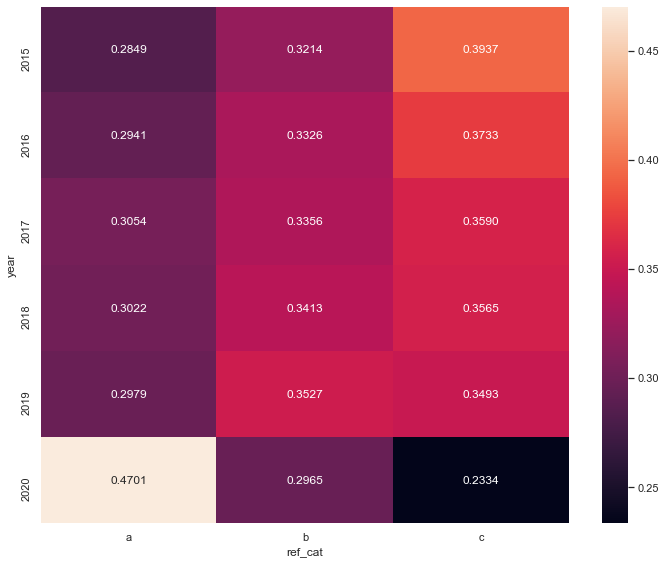

In [179]:
tab=pd.crosstab(df.year,df.ref_cat).apply(f1,axis=1)
sns.set(style='dark')
plt.figure(figsize=(10,8))
ax=sns.heatmap(tab,annot=True,fmt='.04f')
ax.set_ylim(6,0)
plt.tight_layout()
plt.savefig('fig1.png', dpi=400)

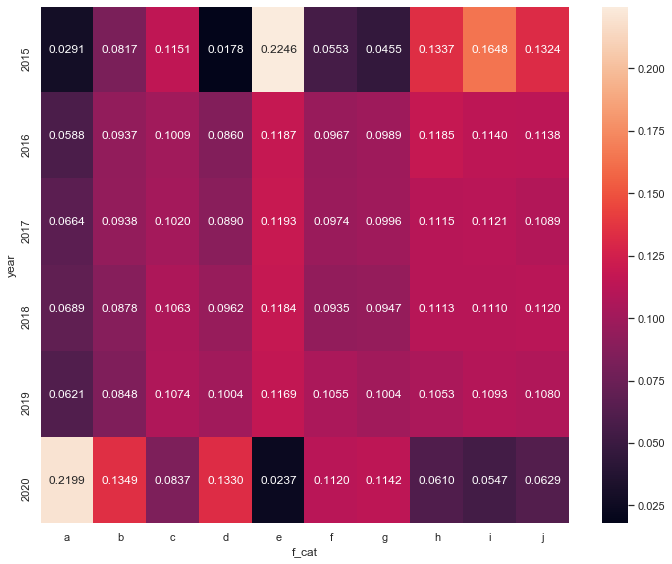

In [180]:
tab=pd.crosstab(df.year,df.f_cat).apply(f1,axis=1)
sns.set(style='dark')
plt.figure(figsize=(10,8))
ax=sns.heatmap(tab,annot=True,fmt='.04f')
ax.set_ylim(6,0)
plt.tight_layout()
plt.savefig('fig1.png', dpi=400)

- <U>2020년에는 환급액 각 그룹별 비중은 환급액이 제일 높은 그룹인 a그룹으로 편중되어 사업소득처럼 큰 변화가 있었다.</U>  
    ('a'그룹 : 환급액 크기 기준 66% 이상 데이터, 'b'그룹 : 환급액 크기 기준 33%이상 66% 미만 데이터, 'c'그룹 : 환급액 크기 기준 33%미만데이터)  
- 반면, 제일 저액의 그룹인 c그룹(약 11%)이 가장 많이 감소하고 중간액의 그룹은 덜 감소하였다.
- 추가로 수수료 금액 그룹도 d그룹 기준으로 상위 그룹의 비중이 증가하였고, 최상위 수수료 그룹이 2020년에 크게 증가하였다.

#### 년도별 나이 그룹별로 차지하는 비중의 변화를 살펴보겠다.

(6, 0)

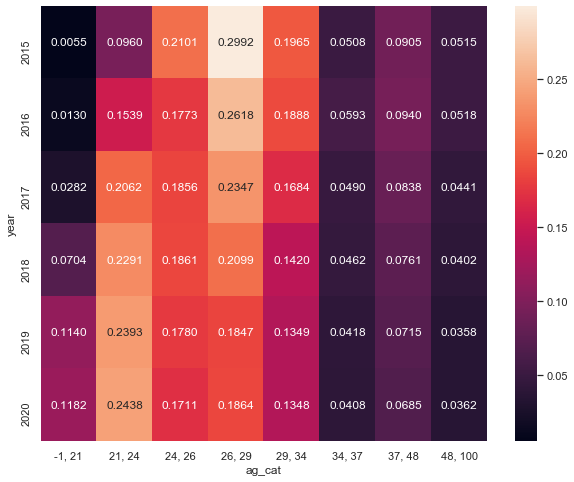

In [145]:
tab=pd.crosstab(df.year,df.ag_cat).apply(f1,axis=1)
sns.set(style='dark')
plt.figure(figsize=(10,8))
ax=sns.heatmap(tab,annot=True,fmt='.04f')
ax.set_ylim(6,0)

- 19년과 20년 사이에 나이그룹의 변화는 거의 없는것으로 보인다.

- 2020년은 결제율은 감소하였으나 결제금액의 총액과 평균은 증가한 시기인데, 사업 소득이 2793000 - 39934000(최고액 그룹)의 범위의 그룹은  
  급증하였으므로 이 그룹의 증가가 결제 금액의 총액의 증가와 밀접한 관련이 있다. 그러므로 이를 기반으로 Action Plan을 설계한다.

#### 사업소득 분류별로 나이대별 차지하는 비중
    
    사업소득 최고액 그룹은 26세 이상의 각 나이 그룹에 해당하는 데이터의 비중이 다른 소득 그룹보다 높다는 것을 알 수 있다.

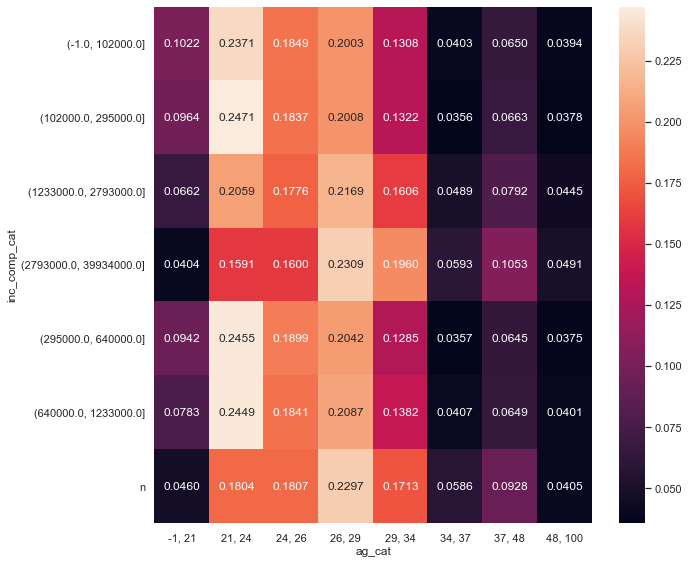

In [181]:
tab=pd.crosstab(df.inc_comp_cat,df.ag_cat).apply(f1,axis=1)
sns.set(style='dark')
plt.figure(figsize=(10,8))
ax=sns.heatmap(tab,annot=True,fmt='.04f')
ax.set_ylim(7,0)
plt.tight_layout()
plt.savefig('fig1.png', dpi=400)

#### 사업소득 카테고리의 최고액 그룹의 성비

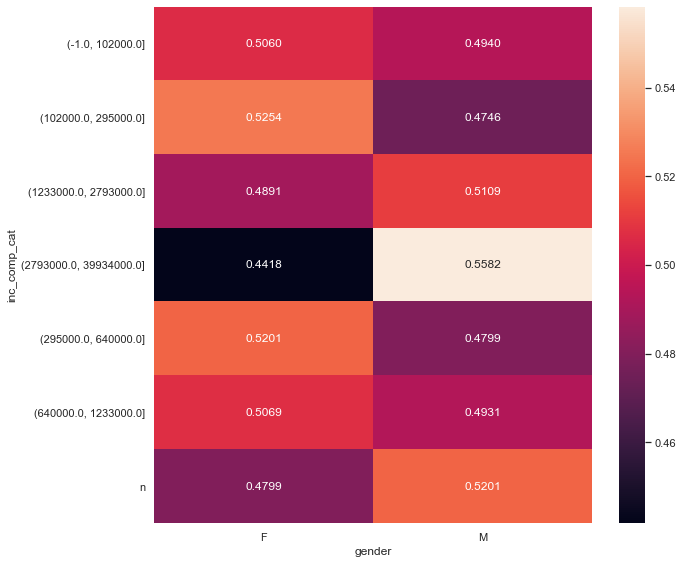

In [182]:
tab=pd.crosstab(df.inc_comp_cat,df.gender).apply(f1,axis=1)
sns.set(style='dark')
plt.figure(figsize=(10,8))
ax=sns.heatmap(tab,annot=True,fmt='.04f')
ax.set_ylim(7,0)
plt.tight_layout()
plt.savefig('fig1.png', dpi=400)

- 사업소득의 최상위 그룹의 남녀 성비차이가 가장 크고, 그 바로 밑의 사업소득 기준 상위 그룹도 성비차이가 다소 발생한다.

#### 최종적으로 Action Plan을 도출하기 위해 아이디어를 점검한다.

In [148]:
a2=df.groupby('ag_cat')['age'].count()

In [149]:
a3=df.groupby('ag_cat')['Target'].sum()

Text(0.5, 1.0, '나이대별 유입 고객')

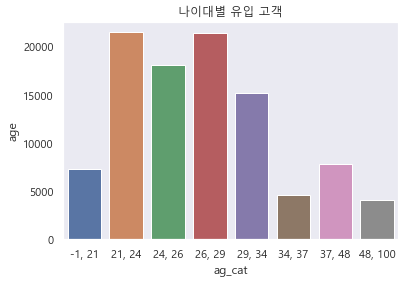

In [183]:
plt.rc('font', family='Malgun Gothic')
sns.barplot(x=a2.index,y=a2)
plt.title("나이대별 유입 고객")

Text(0.5, 1.0, '나이대별 결제금액의 합')

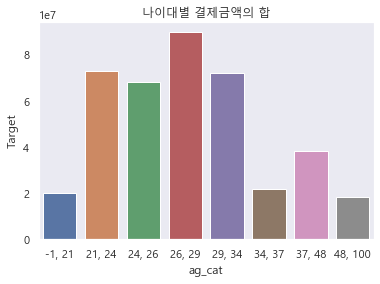

In [184]:
sns.barplot(x=a3.index,y=a3)
plt.title("나이대별 결제금액의 합")

## Ⅲ. Conclusion
### 이상의 내용을 바탕으로 결제급액의 결제금액의 총합을 증가시키기 위해 다음의 결론을 내릴 수 있다.
####    1. 결제여부에 영향을 미치는 변수는 사업소득, 근로소득, 기타소득, 나이이다.(수수료와 환급액 또한 영향을 준다.) 
####    2. 2020년에 총 결제율과 결제데이터의 수는 크게 하락하였으나 결제금액의 평균값과 총합계가 급증했다.
####    3. 2020년에 사업소득이 2,793,000 에서 39,934,000 범위(최상위)에 해당하는 고객은 다른 해에 비해 약 2.9배 증가하였다.
####    4. 사업소득 최상위 그룹은 26세 이상 고객의 비율이 다른 사업소득 그룹보다 높고, 남성의 비율이 다른 사업소득 그룹보다 높다.
####    5. 위 기준(최상위 사업소득,26세 이상,남성)에 해당하는 고객이 가장 많이 쓰는 플랫폼에서 해당 그룹을 타게팅하여 마케팅할  
####       경우 결제 금액 총합계의 증대를 예상할 수 있다.(전체 데이터에서도 21세부터 24세까지와 26세에서 29세사이의 그룹이 유입
####       고객의  수는 비슷하지만  26세에서 29세사이그룹이 결제금액의 합이 제일 높다.)  
<br></br>       
 **< 주관적 아이디어>**
        - 환급액의 2주에서 4주후에 지급된다. 그런데, 토스에서 소정 수수료로 주식매도 당일출금 서비스를 진행한다. 이 경우 단기  
        대출의 형태이지만 소비자들에게는 수수료 몇천원만 내시면 바로 출금하실수 있습니다. 라는 메세지를 보냄으로써 거부감없이  
        편의를 제공한다.
        프리랜서들의 경우 급전이 필요한 경우가 많고, 심리학적으로 금액에 큰 차이가 없다면 대체로 사람들은 돈을 바로 받는 경우  
        를 선호한다. 그러므로,  환급금을 자비스앤빌런즈에서 바로 입금하고 소정의 이자를 결제 창 전에 선택하여 수수료에 추가  
        하는 방향으로 서비스를 추가하면 총결제금액의합을 증대시키는데 도움이 될 것이다. 
        이때 수수료는 환급금액을 기준으로 ① 고액의 경우 % 단위로 메세지에 표기하는 것이 심리적 부담이 적을 것이고, ②천원단위  
        이하의 수수료는 "2000원만 추가하시면 바로 환급금을 받으실 수 있습니다. 받으시겠습니까?" 등으로 금액으로 표기하기 하는  
        것이 결제유도에도 도움이 될 것으로 생각한다. 이때 금액을 설정하면서 AB테스트를 활용하여 조정할 필요가 있다.
        
<br></br>        
**<자비스앤빌런즈 환급일 관련 공지사항 링크>**  
<https://help.3o3.co.kr/hc/ko/articles/900005146883--%EC%8B%A0%EA%B3%A0%EB%A5%BC-%EC%99%84%EB%A3%8C-%ED%95%98%EC%85%A8%EB%8B%A4%EB%A9%B4-%ED%95%84%EB%8F%85-%ED%95%B4%EC%A3%BC%EC%84%B8%EC%9A%94->